In [1]:
# when want to test on test data you have to write
# test_set.dataset.__test__() 
# which now means that all images loaded in (even ones from train & val would have no data augmentation)

In [1]:
# import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import cv2
from PIL import Image, ImageOps
from sklearn.metrics import f1_score
from scipy import stats
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import AlexNet
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from skimage import io, transform
import os
from torch.autograd import Variable

from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.nn as nn
from __future__ import print_function

In [2]:
# import for visualisation of network

!pip install graphviz
!pip install torchviz
import graphviz
import torchviz

!pip install kornia
import kornia 
from kornia import augmentation as aug

In [3]:
# use GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # if on CUDA machine -> should print a CUDA device:
!nvidia-smi  # tells you what GPU you're on

cuda:0
Invalid combination of input arguments. Please run 'nvidia-smi -h' for help.



In [4]:
# global variables

# to specify landmark change 
# 1. landmarks array
# 2. ctr+f 'not general' -> bit in adam optimiser
# 3. change paths 

norm_mean = 180
norm_std = 180

batch_size = 1

landmarks = [3] # brainstem # not general
# sigmas = defaultdict(float) ?
sigmas = {} # sigma per landmark
for k in landmarks:
  sigmas[k] = nn.Parameter(torch.tensor([20.], device = 'cuda'))#.to(device) # what value to initialise sigma
  sigmas[k].requires_grad = True
  #print(sigmas[k])

num_class = len(landmarks)

# input dimensions
in_x = 128
in_y = 128
in_z = 80


# training parameters

epoch_num = 150

alpha = 1/25000
reg = 0.01 # reg = 0.001
gamma = 100000
lr_max = 0.1
lr_min = 0.0001
step_size = 64

threshold_img_print = 0.5

# normalise parameters
normal_min = 15
normal_max = 50
normal_window = 200

# mixed precision
use_amp = True

# if downsampling
downsample_ratio_h = np.empty((0), float)
downsample_ratio_w = np.empty((0), float)
downsample_ratio_d = np.empty((0), float)
downsample_idx_list = np.empty((0), float)


In [5]:
# change path to correct folder 



#from google.colab import drive
#drive.mount('/content/gdrive')
#PATH_OF_DATA= '/content/gdrive/"My Drive"/data/"HNSCC_deepmind_cropped"' # see content of dataset
#!ls {PATH_OF_DATA} # datasets.ImageFolder() expects data as root/label/picture.png
#root = '/content/gdrive/My Drive/data/HNSCC_deepmind_cropped' # note lack of " "


# if doing locally 

# computer

#from google.colab import drive
#drive.mount('/content/gdrive')
#PATH_OF_DATA = r'C:\Users\olive\OneDrive\Documents\CNN\3D_data\HNSCC_deepmind_cropped' # see content of dataset
#!ls {PATH_OF_DATA} # datasets.ImageFolder() expects data as root/label/picture.png
root = r'C:\Users\olive\OneDrive\Documents\CNN\3D_data\HNSCC_deepmind_cropped' # note lack of " "
import os
print(os.getcwd())
os.chdir(root)
print(os.getcwd())


C:\Users\olive\OneDrive\Documents\CNN\Report
C:\Users\olive\OneDrive\Documents\CNN\3D_data\HNSCC_deepmind_cropped


In [31]:
# custom dataset class for the images and masks

import cv2
import random
import sklearn
import skimage.transform as tr
import skimage
import scipy.ndimage


# CTDataset
class CTDataset(Dataset):
    """3D CT Scan dataset."""

    def __init__(self, root, transform_train =None, transform_test = None, test = False):
        """
        Args:
            root (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root
        self.imgs = list(sorted(os.listdir(os.path.join(root, "CTs")))) # ensure they're aligned & index them
        self.structures = list(sorted(os.listdir(os.path.join(root, "Structures"))))
        # self.structure_centres = list(sorted(os.listdir(os.path.join(root, "Structure Centres"))))
        self.transform_train = transform_train
        self.transform_test = transform_test
        self.test = False
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx): # convert tensor to list to index items
            idx = idx.tolist() 
        img_path = os.path.join(self.root, "CTs", self.imgs[idx]) # image path is combination of root and index 
        structure_path = os.path.join(self.root, "Structures", self.structures[idx])
        # structure_centre_path = os.path.join(self.root, "Structure Centres", self.structure_centres[idx])

        img = np.load(img_path) # image read in as numpy array
        structure = np.load(structure_path) # mask - think 0 = background
        # structure_centre = np.load(structure_centre_path)
        
        #print(img.shape)

        sample = {'image': img, 'structure': structure} # both are nd.arrays, stored in sample dataset
        sample['idx'] = idx
        
        if (self.transform_train) and (self.test == False):
            sample = self.transform_train(sample) # if transforms present, act on sample
        if (self.transform_test) and (self.test == True):
            sample = self.transform_test(sample) # if transforms present, act on sample
        
        #sample['idx'] = idx
        
        if (structure.max() != structure.min()): # exclude images where no mask
          #print('mask_max:%5.2f, mask_min:%5.2f' % (mask.max(),mask.min()))
          #print('x where its equal to 1')
          #print((np.where(mask == mask.max())[0]))
          return sample 
        else:
          print('no structure?')
    
    def __len__(self):
        return len(self.imgs) # get size of dataset

    def __test__(self):
      self.test = True
    
    def __train__(self):
      self.train = False

#  -------- think this is redundant ---------
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        sample = self.subset[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.subset)

# --------------------------------------------

class Rescale(object): 
    # need to change rescale so longer side is matched to int and then pad
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # int keeps aspect ratio the same
        self.output_size = output_size

    def __call__(self, sample):
        # image, structure, structure_centre = sample['image'], sample['structure'], sample['structure_centre'] 
        image, structure, idx = sample['image'], sample['structure'], sample['idx']
        #print(mask.max())
        #print(mask.min())
        d, h, w = image.shape[:3] # define image height, width, depth as first 3 values

        
        if isinstance(self.output_size, int): # maintain aspect ratio so no loss of info
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        
        # h and w are swapped for mask because for images,
        # x and y axes are axis 1 and 0 respectively
        img = transform.resize(image, (d, new_h, new_w),preserve_range = True, anti_aliasing = True) # anti-aliasing was false
        structure = transform.resize(structure, (d, new_h,new_w), preserve_range = True,  anti_aliasing = True) # anti-aliasing was false
        #mask_centre =  transform.resize(mask_centre, (new_h,new_w), preserve_range = True, anti_aliasing = True)
        #print(mask.max())
        #print(mask.min())

        return {'image': img, 'structure': structure, 'idx': idx}

class Resize(object):

  def __init__(self, depth, width, height):
      self.depth = depth
      self.width = width
      self.height = height
                          
  def __call__(self, sample):
      image, structure, idx = sample['image'], sample['structure'], sample['idx']
      depth = self.depth # 256 - new width(128)
      width = self.width
      height = self.height
    
      d_pre, h_pre, w_pre = image.shape[:3]
        
      image = skimage.transform.resize(image, (depth, width, height), preserve_range=True, anti_aliasing=True )
      structure = skimage.transform.resize(structure, (depth, width, height), preserve_range=True, anti_aliasing=True )
        
      d_post, h_post, w_post = image.shape[:3]
    
      global downsample_ratio_h
      global downsample_ratio_w
      global downsample_ratio_d
      global downsample_idx_list
      
    
      downsample_ratio_h = np.append(downsample_ratio_h, h_pre/h_post)
      downsample_ratio_w = np.append(downsample_ratio_w, w_pre/w_post)
      downsample_ratio_d = np.append(downsample_ratio_d, d_pre/d_post)
      downsample_idx_list = np.append(downsample_idx_list, idx)     
        
      return {'image':image, 'structure': structure, 'idx': idx} # note note !

class Normalise(object):  
  """ Normalise CT scan in the desired examination window
      takes in image as numpy """
  
  def __init__(self, level_min, level_max, window):
      self.level_min = level_min
      self.level_max = level_max
      self.window = window
                          
  def __call__(self, sample):
      image, structure, idx = sample['image'], sample['structure'], sample['idx']
      # need to normalise around different values
      level = random.randint(self.level_min, self.level_max)
      minval = max(level - self.window/2, 0) # ensures don't go to negative values
      maxval = level + self.window/2
      img_norm = np.clip(image, minval, maxval)
      img_norm -= minval
      img_norm /= self.window
      return {'image':img_norm, 'structure': structure, 'idx': idx} # note note !

class CentreCrop(object):    
  def __init__(self, depth, width, height):
      self.depth = depth
      self.width = width
      self.height = height
                          
  def __call__(self, sample):
      image, structure, idx = sample['image'], sample['structure'], sample['idx']

      d, h, w = image.shape[:3] # define image height, width, depth as first 3 values

      crop_w = (w - self.width) / 2  # 256 - new width(128)
      w_min = w / 4
      crop_h = (h - self.height) / 2
      crop_d = (d - self.depth) / 2
      d_min = crop_d / 4

      image = skimage.util.crop(image, ((0,0),(crop_w, crop_w), (crop_h, crop_h)))
      structure = skimage.util.crop(structure, ((0,0),(crop_w, crop_w),(crop_h,crop_h)))
      if self.depth < d:
        # crop
        crop_d = (d - self.depth) / 2
        
        image = skimage.util.crop(image,((crop_d,crop_d),(0,0),(0,0)))
        structure = skimage.util.crop(structure,((crop_d,crop_d),(0,0),(0,0)))

        new_d = image.shape[0]
        if new_d < self.depth:
          image = skimage.util.pad(image,((0,1),(0,0),(0,0)))
          structure = skimage.util.pad(structure,((0,1),(0,0),(0,0)))
        if new_d > self.depth:
          image = skimage.util.crop(image,((0,1),(0,0),(0,0)))
          structure = skimage.util.crop(structure,((0,1),(0,0),(0,0)))
      
      if self.depth > d:
        # pad
        pad_value = self.depth - d
        image = skimage.util.pad(image,((0,pad_value),(0,0),(0,0)))
        structure = skimage.util.pad(structure,((0,pad_value),(0,0),(0,0)))  

      d, h, w = image.shape[:3] # define image height, width, depth as first 3 values

      return {'image':image, 'structure': structure, 'idx':idx} # note note !

    
    


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, structure, idx = sample['image'], sample['structure'], sample['idx']
        # swap color axis because
        # numpy image: D x H x W 
        # torch image: C X H X W x D
        image = image.transpose(1,2,0)
        structure = structure.transpose(1,2,0)
        image = torch.from_numpy(image).float() # dont know why images/mask casted to float here but need to do it again later
        structure = torch.from_numpy(structure).float()
        structure = structure.unsqueeze(0) # force mask to have extra dimension i.e. (1xHxWxD)
        image = image.unsqueeze(0)
        return {'image': image,'structure': structure, 'idx': idx}

class Flips(object):

    def __call__(self, sample):
      image, structure, idx = sample['image'], sample['structure'], sample['idx']
      if random.random() <= 0.5:
        flip = transforms.Compose([aug.RandomHorizontalFlip3D(p=1, same_on_batch= True)])
        image = flip(image)
        structure = flip(structure)
      return {'image': image, 'structure': structure, 'idx':idx}

class Flips_scipy(object):
    def __call__(self,sample):
        image, structure, idx = sample['image'], sample['structure'], sample['idx']
        random_number = random.random()
        angle = random.randint(-10, 10)
        if random_number <= 0.33:
            image = scipy.ndimage.rotate(image, angle, axes = [1,0],reshape = False, order = 0)
            structure = scipy.ndimage.rotate(structure, angle, axes = [1,0], reshape = False, order = 0)
        if (random_number > 0.33) and (random_number <= 0.66):
            image = scipy.ndimage.rotate(image, angle, axes = [1,2], reshape = False, order = 0)
            structure = scipy.ndimage.rotate(structure, angle, axes = [1,2], reshape = False, order = 0)
        else:
            image = scipy.ndimage.rotate(image, angle, axes = [2,0], reshape = False, order = 0)
            structure = scipy.ndimage.rotate(structure, angle, axes = [2,0], reshape = False, order = 0)
        return {'image': image, 'structure': structure, 'idx': idx}
    
class Horizontal_flip(object):
    def __call__(self,sample):
        image, structure, idx = sample['image'], sample['structure'], sample['idx']
        random_number = random.random()
        if random_number <= 0.5:
            #print('image shape', image.shape)
            image = np.flip(image, axis = 2).copy()
            structure = np.flip(structure, axis = 2).copy()
            #print('horizontal flipped')
        return {'image': image, 'structure': structure, 'idx': idx}
       
    
class Upsidedown_scipy(object):
    def __call__(self,sample):
        image, structure, idx = sample['image'], sample['structure'], sample['idx']
        # if upside down need to flip
        # if left cochlea landmark = 5 above 1/2
        # data is y, x, z
        landmark_loc = np.where(structure == 5)
        if landmark_loc[0].size == 0: # if no 5 present check for 6
            landmark_loc = np.where(structure == 6)
            if landmark_loc[0].size == 0: # no 5 or 6 present just return image and structure
                return {'image': image, 'structure': structure, 'idx': idx}
            else:
                z_landmark = landmark_loc[0][0]
                z_size = structure.shape[0] 
                if z_landmark < z_size/2:
                    angle = 180
                    image = scipy.ndimage.rotate(image, angle, axes = [2,0], reshape = False, order =0)
                    #rotate(input, angle, axes=1, 0, reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)
                    structure = scipy.ndimage.rotate(structure, angle, axes = [2,0], reshape = False, order =0)
                    return {'image': image, 'structure': structure, 'idx': idx}
                else:
                    return {'image': image, 'structure': structure, 'idx': idx}
                    
        else:
            z_landmark = landmark_loc[0][0]
            z_size = structure.shape[0] 
            if z_landmark < z_size/2:
                angle = 180
                image = scipy.ndimage.rotate(image, angle, axes = [2,0],reshape = False, order =0)
                #rotate(input, angle, axes=1, 0, reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)
                structure = scipy.ndimage.rotate(structure, angle, axes = [2,0], reshape = False, order =0)
                return {'image': image, 'structure': structure, 'idx': idx}
            else:
                return {'image': image, 'structure': structure, 'idx': idx}
        
    
class Upsidedown(object):
  def __call__(self,sample):
    image, structure, idx = sample['image'], sample['structure'], sample['idx']
    # if upside down need to flip
    # if left cochlea landmark = 5 above 1/2
    # note that cause kornea takes in z, y, x between pre and post tranpose
    # data is z, y, x
    # com structure takes in y, x, z -> x, y, z
    # therefore if take in z, y, x -> y, z, x (*1)
    structure_com = com_structure(structure.unsqueeze(0), 5)
    structure_com_z = structure_com[0][0][1] # see (*1)
    z_size = structure.size()[1] # cause in this section is z, y, x
    #print(structure_com_z, z_size/2)
    if structure_com_z < z_size/2:
      flip = transforms.Compose([aug.RandomVerticalFlip3D(p=1)])
      image = flip(image)
      structure = flip(structure)
    #structure = torch.squeeze(structure,0)
    return {'image': image, 'structure': structure, 'idx': idx}

class Unsqueeze(object):
  def __call__(self,sample):
    image, structure, idx = sample['image'], sample['structure'], sample['idx']
    image = image.unsqueeze(0)
    structure = structure.unsqueeze(0)
    return {'image': image, 'structure': structure, 'idx': idx}




# for now not going to use below because not sure if it acts on image and structure equally
class Affine(object):
  def __call__(self, sample):
    image, structure, idx = sample['image'], sample['structure'], sample['idx']
    if random.random() <= 0.3:
      affine = transforms.Compose([aug.RandomAffine3D(degrees=(0,10,10), translate=(0,0.05,0.05), same_on_batch=True, p=1)])
      image = affine(image)
      print('affined')
      structure = affine(structure)


    return{'image': image, 'structure': structure, 'idx': idx}

class Noise(object):  # helps prevent overfitting
  #Random noise images
  def __call__(self,sample):
    image, structure, idx = sample['image'], sample['structure'], sample['idx']
    if random.random() <= 1:
      noise = transforms.Compose(aug.RandomMotionBlur3D(5, 10, direction=0, p=1))
      image = noise(image)
    return {'image': image, 'structure': structure, 'idx': idx}

class Noise1(object):  # helps prevent overfitting
 # Random noise images
  def __call__(self,sample):
    image, structure= sample['image'], sample['structure']
    if random.random() <= 1:
      image = skimage.util.random_noise(image, mean = 0, var = 1.0000000001, clip = False)
      # would this work given that mask is unchanged??
    return {'image': image, 'structure': structure}
class Pre_Transpose(object):
  def __call__(self, sample):
    image, structure = sample['image'], sample['structure']
    image = torch.transpose(image, 1, 3)
    image = torch.transpose(image, 2, 3)
    structure = torch.transpose(structure, 1, 3)
    structure = torch.transpose(structure, 2, 3)

    return {'image': image, 'structure': structure}

class Post_Transpose(object):
  def __call__(self, sample):
    image, structure = sample['image'], sample['structure']
    #torch.squeeze(image, 0)
    #torch.squeeze(structure, 0)

    structure = torch.squeeze(structure,0)
    image = torch.squeeze(image, 0)
    #torch.squeeze(structure,0)
    #torch.squeeze(image, 0)
    image = torch.transpose(image, 3, 2)
    image = torch.transpose(image, 3, 1)
    structure = torch.transpose(structure, 3, 2)
    structure = torch.transpose(structure, 3, 1)

    return {'image': image, 'structure': structure}
'''
class Squeeze(object):
  def __call__(self, sample):
    image, structure = sample['image'], sample['structure']
    image = torch.squeeze(image, 0)
    print('squeeze')
    structure = torch.squeeze(structure, 0)
    return {'image': image, 'structure': structure}
'''


"\nclass Squeeze(object):\n  def __call__(self, sample):\n    image, structure = sample['image'], sample['structure']\n    image = torch.squeeze(image, 0)\n    print('squeeze')\n    structure = torch.squeeze(structure, 0)\n    return {'image': image, 'structure': structure}\n"

In [32]:
# functions

def com_structure(heatmap, landmark): # assumes 1 channel
  # heatmap is batch of either masks or image of 
  # heatmap dim is (B x C x H x W x D)
  # output is (B x coord)
  # i.e. x,y,z of 3rd image = coords[3][0],coords[3coo][1], coords[3][2] only 1 channel
  batch_size = (heatmap.size()[0])
  landmark_present = []
  landmark = float(landmark) # ensure that comparison is made properly
  for i in range(batch_size):
    # heatmap shape [1, 1, 256, 256, 100] i.e. B x C x H x W x D
    locations = (heatmap[i][0] == landmark).nonzero().to(device)
    if (locations.size(0) == 0): # if no landmarks detected for image in batch
      print('no structure for %1.0f' % landmark)
      print('heatmap maximum value %5.2f' % heatmap[i][0].max())
      print('heatmap minimum value %5.2f' % heatmap[i][0].min())
      landmark_present.append(False)
      x_com = torch.tensor(0, dtype = torch.float64).to(device) # in theory this should not be used
      y_com = torch.tensor(0, dtype = torch.float64).to(device)
      z_com = torch.tensor(0, dtype = torch.float64).to(device)
    else:
      landmark_present.append(True)
      x_com = torch.tensor(0, dtype = torch.float64).to(device)
      y_com = torch.tensor(0, dtype = torch.float64).to(device)
      z_com = torch.tensor(0, dtype = torch.float64).to(device)
      for k in range(locations.size(0)): # number of landmarks
        x_com += locations[k][1]
        y_com += locations[k][0]
        z_com += locations[k][2]
      x_com /= locations.size(0)
      y_com /= locations.size(0)
      z_com /= locations.size(0)

    if i == 0:
      coords = torch.tensor([[x_com,y_com,z_com]]).to(device)
    else: 
      coords_temp = torch.tensor([[x_com,y_com,z_com]]).to(device)
      coords = torch.cat((coords,coords_temp),dim = 0)
  # returns arrays of B x coord
  # returns array of B x True/False
  # if True then for that coord it is COM, if false then need to produce heatmap of zeros
  return coords, landmark_present   

def top_structure(heatmap, landmark): # assumes 1 channel
  # heatmap is batch of either masks or image of 
  # heatmap dim is (B x C x H x W x D)
  # output is (B x coord)
  # i.e. x,y,z of 3rd image = coords[3][0],coords[3][1], coords[3][2] only 1 channel
  batch_size = (heatmap.size()[0])
  landmark_present = []
  landmark = float(landmark) # ensure that comparison is made properly
  for i in range(batch_size):
    # heatmap shape [1, 1, 256, 256, 100] i.e. B x C x H x W x D
    locations = (heatmap[i][0] == landmark).nonzero().to(device)
    if (locations.size(0) == 0): # if no landmarks detected for image in batch
      print('no structure for %1.0f' % landmark)
      print('heatmap maximum value %5.2f' % heatmap[i][0].max())
      print('heatmap minimum value %5.2f' % heatmap[i][0].min())
      landmark_present.append(False)
      x_top = torch.tensor(0, dtype = torch.float64).to(device) # in theory this should not be used
      y_top = torch.tensor(0, dtype = torch.float64).to(device)
      z_top = torch.tensor(0, dtype = torch.float64).to(device)
    else:
      landmark_present.append(True)
      x_top = torch.tensor(0, dtype = torch.float64).to(device)
      y_top = torch.tensor(0, dtype = torch.float64).to(device)
      z_top = torch.tensor(0, dtype = torch.float64).to(device)
      for k in range(locations.size(0)): # number of landmarks present in the image i.e. number of 3s in image
        # assumes image right way up 
        if (locations[k][2] > z_top): 
            x_top = locations[k][1]
            y_top = locations[k][0]
            z_top = locations[k][2]
    if i == 0:
      coords = torch.tensor([[x_top,y_top,z_top]]).to(device)
    else: 
      coords_temp = torch.tensor([[x_top,y_top,z_top]]).to(device)
      coords = torch.cat((coords,coords_temp),dim = 0)
  # returns arrays of B x coord
  # returns array of B x True/False
  # if True then for that coord it is TOP, if false then need to produce heatmap of zeros
  return coords, landmark_present  

def landmarks_coords(heatmap, landmark):
  # heatmap is batch of either masks or image of 
  # heatmap dim is (B x C x H x W x D)
  # output is (B x coords)
  # i.e. first (x,y,z) of 3rd image = coords[3][0]
  # i.e. second (x,y,z) of 3rd image = coords[3][1]
  batch_size = (heatmap.size()[0])
  landmark_present = []
  landmark = float(landmark) # ensure that comparison is made properly
  for i in range(batch_size):
    locations = (heatmap[i][0] == landmark).nonzero()
    if (locations.size(0) == 0): # if no landmarks detected for image in batch
      print('no structure for %1.0f' % landmark)
      print('heatmap maximum value %5.2f' % heatmap[i][0].max())
      landmark_present.append(False)
      x_com = torch.tensor(0, dtype = torch.float64).to(device) # in theory this should not be used
      y_com = torch.tensor(0, dtype = torch.float64).to(device)
      z_com = torch.tensor(0, dtype = torch.float64).to(device)
    else:
      landmark_present.append(True)
      # --- rewrite ---
      locations = locations.transpose(1,0,2) # not sure if this will work but need to change so have x,y,z
      if i == 0:
        coords = torch.tensor(locations).to(device) # coords should be array type object of x,y,z for each i (== image)
      else:
        coords_temp = torch.tensor(locations).to(device)
        coords = torch.cat((coords,coords_temp),dim = 0) # coords by the end will be B x coords_array_per_image
  # returns array of B x True/False
  # if True then has x,y,z of all posn of that landmark, if False then need to produce heatmap of zeros
  return coords, landmark_present   


from scipy import optimize
from scipy.optimize import curve_fit

# takes in heatmap of B x C x H x W x D
# i.e. batch x 6 channels x H x W x D
# needs to workout max (x,y,z) for specified landmark
def pred_max(heatmap, landmark): 
  a = torch.max(heatmap, dim = 4, keepdim = True)
  b = torch.max(a[0],dim =3,keepdim = True)
  c = torch.max(b[0],dim = 2,keepdim = True)
  batch_size = (heatmap.size()[0])
  for i in range(batch_size):
    index = landmarks.index(landmark)
    y = c[1][i][index][0][0][0]
    x = b[1][i][index][y][0][0]
    z = a[1][i][index][y][x][0]
    if i == 0:
      coords = torch.tensor([[x,y,z]]).to(device)
    else: 
      coords_temp = torch.tensor([[x,y,z]]).to(device)
      coords = torch.cat((coords,coords_temp),dim = 0)

  return coords   

# pred max gives maximum for each z layer between certain range of z 

def gauss_max(heatmap, landmark, height_trained, sigma_trained): # this should be current sigma for landmark
    # heatmap is batch of masks or images of dim (B x C x H x W x D)
    # output is (B x coord)
    # i.e. x,y of 3rd image = coords[3][0], coords[3][1] only 1 channel
    pred_coords = pred_max(heatmap, landmark).cpu().numpy()
    batch_size = (heatmap.size()[0])
    heatmap = heatmap.detach().cpu().numpy()
    index = landmarks.index(landmark)
    for i in range(batch_size):
        t = np.indices((in_y,in_x,in_z)).astype(float)  ## will be ~100,256,256 in your case
        def f(t, mu_i, mu_j, mu_k, height, sigma):                 ## function to be fitted
            pos = np.array([mu_i, mu_j, mu_k])      ## central position of the gaussian peak (using initial estimate of the argmax)
            t = t.reshape((3,in_y,in_x,in_z))           ## will be ~100,256,256 in your case
            dist_map = np.sqrt(np.sum([np.power((t[0] - pos[0]), 2), np.power((t[1] - pos[1]), 2), np.power((in_y/in_z * (t[2] - pos[2])), 2)], axis=0))  ## generate euclidean distance map to sample gauss fn on
            gauss = height * np.exp( - dist_map/ (2.*sigma*sigma) )
            return np.array(gauss, dtype=float).ravel()  ## generate gaussian using the estimated central point (your gauss scale will be different here too)
        #argmax_pred = np.unravel_index(torch.argmax(model_output[0]), model_output.size()[2:])  ## get initial guess of gauss peak (prediction argmax)
        #optimum_pos = curve_fit(f, t.ravel(), model_output[0].numpy().ravel(), p0=argmax_pred) ## optimisation process, compare predicted heatmap with generated gaussians (centre point shifted around to optimum)
        p0 = [pred_coords[i][0], pred_coords[i][1],pred_coords[i][2], height_trained, sigma_trained]
        
        # catch error
        try:
            params = curve_fit(f, t.ravel() , heatmap[i][index].ravel(), p0 = p0)          
            x = params[0][1]
            y = params[0][0]
            z = params[0][2]  

        except RuntimeError:
            print("Error - curve_fit failed")
            x = torch.tensor(0) # change !!!
            y = torch.tensor(0)
            z = torch.tensor(0)
        
        #print(params[0])
        #print(params[1])
        #print(params[2])
        

        x_max = heatmap.shape[3]
        y_max = heatmap.shape[2]
        z_max = heatmap.shape[4]
        x = max(0,min(x,x_max)) # keep x & y in [0,224]
        y = max(0,min(y,y_max))
        z = max(0,min(z,z_max))
        if i == 0:
            coords = torch.tensor([[x,y,z]])
        else: 
            coords_temp = torch.tensor([[x,y,z]])
            coords = torch.cat((coords,coords_temp),dim = 0)
        
    return coords   
        
   

In [33]:
# dataloaders

trans_plain = transforms.Compose([Normalise(normal_min, normal_max, normal_window), Resize(in_z,in_x,in_y), Upsidedown_scipy(), ToTensor()])
trans_augment = transforms.Compose([Normalise(normal_min, normal_max, normal_window),Resize(in_z,in_x,in_y), Upsidedown_scipy(), Flips_scipy(), Horizontal_flip(),ToTensor()])
#trans_plain = transforms.Compose([Normalise(normal_min, normal_max, normal_window), Depth(100,256,256), Upsidedown_scipy(), ToTensor()])
#trans_augment = transforms.Compose([Normalise(normal_min, normal_max, normal_window),Depth(100,256,256), Upsidedown_scipy(), Flips_scipy(), ToTensor()])#, Pre_Transpose(), Check_com_present('bob'), Post_Transpose()])#,  Upsidedown(),Flips(), CentreCrop(), Affine(), Post_Transpose()])#HorizontalFlip()Noise(),, Affine() CentreCrop()CentreCrop(), Flips(), Affine(),
# torch image: C X H X W x D -> this is output and what we deal with from now on
# Upsidedown(), Flips(), CentreCrop(), Affine()

dataset = CTDataset(root, transform_train = trans_augment, transform_test = trans_plain, test = False )

# split data in train/val/test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(0))
# manual seed ensures that same split everytime to ensure testing on correct dataset!
# i.e. if random split, train, save, random split, test -> may end up testing on same as training!


image_datasets = {
    'train': train_set, 'val': val_set, 'test':test_set
}

# Load data in
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set,batch_size = batch_size, shuffle = False, num_workers=0)
}

# check dataloaders working
#print(train_set.__getitem__(0)['image'].size()) # i.e. 1 x 224 x 224 as torch tensor (C x H x W)
#print(train_set.__getitem__(0)['structure'].size()) 


for i in range(1):
    print(train_set.__getitem__(i)['structure'].size()) # i.e. 1 x 224 x 224 as torch tensor (C x H x W)
    for l in landmarks:
        print(com_structure(train_set.__getitem__(i)['structure'].unsqueeze(0), l))
    print('for image %1.0f' % i)
    #print(train_set.__getitem__(i)['structure'].size()) 


#img = dataset.__getitem__(10)['image']
#idx = dataset.__getitem__(10)['idx']
#print(idx)


torch.Size([1, 128, 128, 80])
(tensor([[62.3448, 55.6897, 57.8448]], device='cuda:0', dtype=torch.float64), [True])
for image 0


In [34]:
# gradient accumulation
# batch accumulation needs to be equal to the batch number will end on i.e. batch size 10, 73 images
# batch accumulation = 8
import math
batch_accumulation = math.ceil(train_set.__len__()/batch_size) # rounds it up

tensor(4.)
(128, 128, 80)


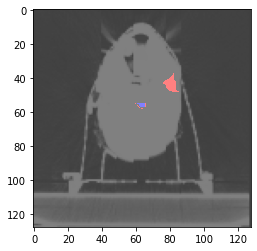

In [35]:


# plot 2D slice



image = train_set.__getitem__(0)['image']
structure = train_set.__getitem__(0)['structure']

print(structure.max())

img = image.numpy().squeeze(0)
structure = structure.numpy().squeeze(0)

print(img.shape)
plt.figure()
img = img[:, :, 50]
structure = structure[:, :, 50]

plt.imshow(img,cmap = 'Greys_r', alpha = 0.5)

# define the colors
cmap = matplotlib.colors.ListedColormap(['0','r', 'k','b','g','y','m'])

# create a normalize object the describes the limits of
# each color
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


# plot it
plt.imshow(structure, cmap = cmap, norm = norm, alpha = 0.5 )
plt.show()



<built-in method type of Tensor object at 0x0000020366EC56C0>
0.61
(tensor([[63.2429, 56.5932, 57.8644]], device='cuda:0', dtype=torch.float64), [True])
torch.Size([1, 128, 128, 80])


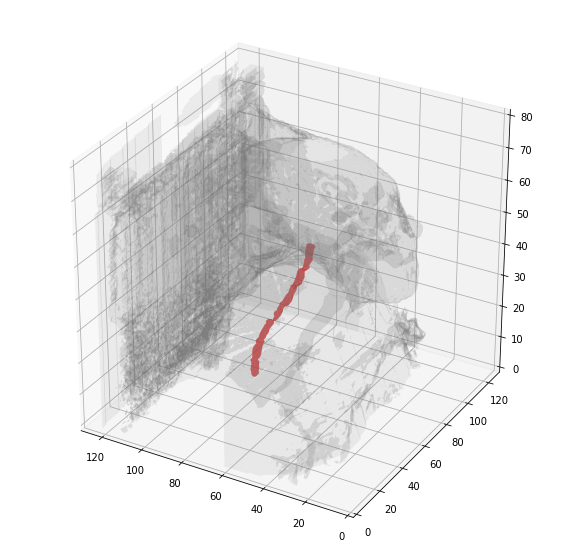

In [30]:
# plot 3D



import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import axes3d



#print(matplotlib.rcsetup.all_backends)
#matplotlib.use('TkAgg',warn=False, force=True)
%matplotlib inline
matplotlib.pyplot.ion()



def plot_3d(image, structure, threshold_img, threshold_structure):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    #p = image.transpose(2,1,0)
    print(train_set.__getitem__(0)['image'].size())
    
    verts_img, faces_img = measure.marching_cubes_classic(image, threshold_img)
    verts_structure, faces_structure = measure.marching_cubes_classic(structure, threshold_structure)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh_img = Poly3DCollection(verts_img[faces_img], alpha=0.1)
    mesh_structure = Poly3DCollection(verts_structure[faces_structure], alpha=0.6)
    #face_color_img = [0.5, 0.5, 1]
    face_color_img = ['tab:gray']
    mesh_img.set_facecolor(face_color_img)
    #face_color_structure = ['r', 'b', 'g']
    face_color_structure = ['tab:red']
    mesh_structure.set_facecolor(face_color_structure)
    ax.add_collection3d(mesh_img)
    ax.add_collection3d(mesh_structure)

    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(0, image.shape[0])
    ax.set_zlim(0, image.shape[2])

    ax.invert_xaxis()

    # rotate the axes and update
    ax.mouse_init(rotate_btn=1, zoom_btn=3)

    plt.show()

image_3d = train_set.__getitem__(0)['image']
print(image_3d.type)
image_3d = image_3d.squeeze(0)
image_3d = image_3d.numpy()

max_value = np.max(image_3d)
print(max_value)

structure_3d = train_set.__getitem__(0)['structure']
structure_3d = structure_3d.squeeze(0)
structure_3d = structure_3d.numpy()

for l in landmarks:
    print(com_structure(train_set.__getitem__(0)['structure'].unsqueeze(0), l))

plot_3d(image_3d,structure_3d,max_value/2, 6)



In [36]:
# network

import torch
from torch import nn
import torch.nn.functional as F

# UNET3D

unet_feat = 8

class ConvUnit(nn.Module):
    """
        Convolution Unit: (Conv3D -> BatchNorm -> ReLu) * 2
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True), # inplace=True means it changes the input directly, input is lost

            #nn.Conv3d(out_channels, out_channels, kernel_size = 3, padding = 1),
            #nn.BatchNorm3d(out_channels),
            #nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

class EncoderUnit(nn.Module):
    """
    An Encoder Unit with the ConvUnit and MaxPool
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2),
            ConvUnit(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

class DecoderUnit(nn.Module):
    """
    ConvUnit and upsample with Upsample or convTranspose
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvUnit(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)

class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, s_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.s_channels = s_channels

        self.conv = ConvUnit(in_channels, s_channels)
        self.enc1 = EncoderUnit(s_channels, 2 * s_channels)
        self.enc2 = EncoderUnit(2 * s_channels, 4 * s_channels)
        self.enc3 = EncoderUnit(4 * s_channels, 8 * s_channels)
        self.enc4 = EncoderUnit(8 * s_channels, 8 * s_channels)

        self.dec1 = DecoderUnit(16 * s_channels, 4 * s_channels)
        self.dec2 = DecoderUnit(8 * s_channels, 2 * s_channels)
        self.dec3 = DecoderUnit(4 * s_channels, s_channels)
        self.dec4 = DecoderUnit(2 * s_channels, s_channels)
        self.out = OutConv(s_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        x6 = self.dec1(x5, x4)
        x7 = self.dec2(x6, x3)
        x8 = self.dec3(x7, x2)
        x9 = self.dec4(x8, x1)
        output = self.out(x9)
        return output 
        
# SCNET 3D

features = 24
dilation = [1,1,1]

# 4 features goes through test


class SCNET(nn.Module): # need to add bottleneck
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        #initialise sigma to model
        
        # Local appearance
        
        # initialise sigma
        #self.
        

        # block 1
        self.conv1 = self.conv_block1(in_channels, features, 3, 1) 
        self.conv2 = self.conv_block1(features, features, 3, 1)
        self.conv3 = self.conv_block1(features,features,3, 1)

        # block 2
        self.pool_block_2 = self.pool_layer_block_2()

        # block 3
        self.conv4 = self.conv_block3(features, features, 3, 1) # note conv4 acts on pool, which acts on conv2
        self.conv5 = self.conv_block3(features, features, 3, 1)
        self.conv6 = self.conv_block3(features,features,3, 1)

        # block 4
        self.pool_block_4 = self.pool_layer_block_4()

        # block 5
        self.conv7 = self.conv_block5(features, features, 3, 1) # note conv7 acts on pool, which acts on conv5
        self.conv8 = self.conv_block5(features, features, 3, 1)
        self.conv9 = self.conv_block5(features,features,3, 1)

        # block 6
        self.upsample_block_6 = self.upsample_layer_block_6(features)

        # block 7
        # addition
        self.upsample_block_7 = self.upsample_layer_block_7(features)


        # block 8
        # addition
        self.conv10 = self.conv_block8(features, out_channels, 3, 1)

        # Spatial configuration

        # block 9
        self.pool_block_9 = self.pool_layer_block_9()

        # block 10
        self.conv11 = self.conv_block10(out_channels, features, 3, 1) 
        self.conv12 = self.conv_block10(features, features, 3, 1)
        self.conv13 = self.conv_block10(features,features,3, 1)

        # block 11
        self.upsample_block_11 = self.upsample_layer_block_11(features, out_channels)

        # block 12
        # multiplication


    def __call__(self, x):

        # block 1
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        # block 2
        pool_block_2 = self.pool_block_2(conv2) # note middle one

        # block 3
        conv4 = self.conv4(pool_block_2)
        conv5 = self.conv5(conv4)
        conv6 = self.conv6(conv5)

        # block 4
        pool_block_4 = self.pool_block_4(conv5)

        # block 5
        conv7 = self.conv7(pool_block_4)
        conv8 = self.conv8(conv7)
        conv9 = self.conv9(conv8)

        # block 6
        upsample_block_6 = self.upsample_block_6(conv9)

        # block 7
        add_block_7 = conv6 + upsample_block_6
        upsample_block_7 = self.upsample_block_7(add_block_7)

        # block 8
        add_block_8 = upsample_block_7 + conv3
        conv10 = self.conv10(add_block_8)

        # block 9
        pool_block_9 = self.pool_block_9(conv10)

        # block 10
        conv11 = self.conv11(pool_block_9)
        conv12 = self.conv12(conv11)
        conv13 = self.conv13(conv12)

        # block 11
        upsample_block_11 = self.upsample_block_11(conv13)

        # block 12
        output = upsample_block_11 * conv10

        return output

    def conv_block1(self, in_channels, out_channels, kernel_size, padding):

        conv_block1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, dilation = dilation, padding = padding), # add dilation
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU()
        )
        return conv_block1

    def pool_layer_block_2(self):

        pool_layer_block_2 = nn.Sequential(
            nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        )

        return pool_layer_block_2
    
    def conv_block3(self, in_channels, out_channels, kernel_size, padding):

        conv_block2 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, dilation = dilation, padding = padding), # add dilation
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU()
        )
        return conv_block2

    def pool_layer_block_4(self):

        pool_layer_block_4 = nn.Sequential(
            nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        )

        return pool_layer_block_4
    
    def conv_block5(self, in_channels, out_channels, kernel_size, padding):

        conv_block5 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, dilation = dilation, padding = padding), # add dilation
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU()
        )
        return conv_block5
    
    def upsample_layer_block_6(self, channels):

        upsample_block_6 = nn.Sequential(
          nn.ConvTranspose3d(channels, channels, kernel_size = 3, stride = 2, padding = 1, output_padding=1) # add dilation
        )
        return upsample_block_6
    
    def upsample_layer_block_7(self, channels):

        upsample_block_7 = nn.Sequential(
          nn.ConvTranspose3d(channels, channels, kernel_size = 3, stride = 2, padding = 1, dilation = dilation, output_padding=1) # add dilation
        )
        return upsample_block_7

    def conv_block8(self, in_channels, out_channels, kernel_size, padding):

        conv_block8 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, dilation = dilation, padding = padding), # add dilation
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU()
        )
        return conv_block8

    def pool_layer_block_9(self):

        pool_layer_block_9 = nn.Sequential(
            nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        )

        return pool_layer_block_9

    def conv_block10(self, in_channels, out_channels, kernel_size, padding):

        conv_block10 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, dilation = dilation, padding = padding), # add dilation
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU()
        )
        return conv_block10

    def upsample_layer_block_11(self, in_channels, out_channels):

        upsample_block_11 = nn.Sequential(
          nn.ConvTranspose3d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1,dilation = dilation, output_padding=1) # add dilation
        )
        return upsample_block_11


# Model summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet3d(1,num_class, unet_feat)
model = model.to(device)

from torchsummary import summary
summary(model, input_size=(1, in_y, in_x, in_z))

Layer (type:depth-idx)                   Param #
├─ConvUnit: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─Conv3d: 3-1                  224
|    |    └─BatchNorm3d: 3-2             16
|    |    └─ReLU: 3-3                    --
├─EncoderUnit: 1-2                       --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool3d: 3-4               --
|    |    └─ConvUnit: 3-5                3,504
├─EncoderUnit: 1-3                       --
|    └─Sequential: 2-3                   --
|    |    └─MaxPool3d: 3-6               --
|    |    └─ConvUnit: 3-7                13,920
├─EncoderUnit: 1-4                       --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool3d: 3-8               --
|    |    └─ConvUnit: 3-9                55,488
├─EncoderUnit: 1-5                       --
|    └─Sequential: 2-5                   --
|    |    └─MaxPool3d: 3-10              --
|    |    └─ConvUnit: 3-11               110,784
├─DecoderU

Layer (type:depth-idx)                   Param #
├─ConvUnit: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─Conv3d: 3-1                  224
|    |    └─BatchNorm3d: 3-2             16
|    |    └─ReLU: 3-3                    --
├─EncoderUnit: 1-2                       --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool3d: 3-4               --
|    |    └─ConvUnit: 3-5                3,504
├─EncoderUnit: 1-3                       --
|    └─Sequential: 2-3                   --
|    |    └─MaxPool3d: 3-6               --
|    |    └─ConvUnit: 3-7                13,920
├─EncoderUnit: 1-4                       --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool3d: 3-8               --
|    |    └─ConvUnit: 3-9                55,488
├─EncoderUnit: 1-5                       --
|    └─Sequential: 2-5                   --
|    |    └─MaxPool3d: 3-10              --
|    |    └─ConvUnit: 3-11               110,784
├─DecoderU

In [37]:
# more useful functions

import sys, csv ,operator


def point_to_point(mask_x, mask_y, mask_z, pred_x, pred_y, pred_z):
  # calculates point to point error for image
  point_to_point = ((pred_x - mask_x)**2 + (pred_y - mask_y)**2 + (pred_z - mask_z)**2)**0.5 
  return point_to_point

def point_to_point_mm(mask_x, mask_y, mask_z, pred_x, pred_y, pred_z, image_idx):
  # calculates point to point in mm
  data = csv.reader(open(os.path.join(root, 'image_dimensions.csv')),delimiter=',')
  next(data) # skip first line
  sortedlist = sorted(data, key=operator.itemgetter(0))
  # sortedlist[img_number][0 = name, 1 = x/y, 2 = z]
  image_idx = int(image_idx)
  pixel_mm_x = sortedlist[image_idx][1] # 1 pixel = pixel_mm_x * mm
  pixel_mm_y = sortedlist[image_idx][1]
  pixel_mm_z = sortedlist[image_idx][2]
  if downsample_idx_list.size:
        # array not emtpy
        index = np.where(downsample_idx_list==image_idx)
        #print('pre amendment pixel sizes', pixel_mm_x, pixel_mm_y, pixel_mm_z)
        pixel_mm_x = float(pixel_mm_x) * downsample_ratio_w[index[0][0]]
        pixel_mm_y = float(pixel_mm_y) * downsample_ratio_h[index[0][0]]
        pixel_mm_z = float(pixel_mm_z) * downsample_ratio_d[index[0][0]]
        pixel_mm_x = torch.tensor((pixel_mm_x)).to(device)
        pixel_mm_y = torch.tensor((pixel_mm_y)).to(device)
        pixel_mm_z = torch.tensor((pixel_mm_z)).to(device)
        #print('post amendment pixel sizes', pixel_mm_x, pixel_mm_y, pixel_mm_z)
  else:
      pixel_mm_x = torch.tensor(float(pixel_mm_x)).to(device)
      pixel_mm_y = torch.tensor(float(pixel_mm_y)).to(device)
      pixel_mm_z = torch.tensor(float(pixel_mm_z)).to(device)
  point_to_point = (((pred_x - mask_x)*pixel_mm_x)**2 + ((pred_y - mask_y)*pixel_mm_y)**2 + ((pred_z - mask_z)*pixel_mm_z)**2)**0.5 
  return point_to_point


def gaussian(x,y,z, targ_coords, sigma, gamma, dimension = 3): # assumes in 2d space
  # x, y are general coords and targ_coords define mean of gaussian
  x_targ, y_targ, z_targ = targ_coords[0], targ_coords[1], targ_coords[2]
  l2_dif = torch.tensor(-((x-x_targ)**2 + (y- y_targ)**2 + (z-z_targ)**2)/(2*sigma**2)).to(device)
  gauss = torch.tensor((gamma) * (2*np.pi)**(-dimension/2) * sigma ** (-dimension) ** torch.exp(l2_dif)).to(device)
  return gauss

def gaussian_map(peak_x,peak_y,peak_z, sigma,gamma,x_size,y_size, z_size, output,dimension = 3): # 2D gaussian 5x5 image
  if output == False: # expands gaussian map to 448x448 to ensure proper normalisation ? not working
    y,x,z = np.ogrid[0:2*y_size,0:2*x_size, 0:2*z_size]
    peak_x = peak_x + x_size/2
    peak_y = peak_y + y_size/2
    peak_z = peak_z + z_size/2
    pre_factor = ((gamma) * (2*np.pi)**(-dimension/2) * sigma ** (-dimension)) 
    h = pre_factor * torch.exp( -((torch.tensor(x).to(device)-peak_x)**2 + (torch.tensor(y).to(device)-peak_y)**2 + (torch.tensor(z).to(device)-peak_z)**2) / (2.*sigma*sigma) )
  if output == True:
    y,x,z = np.ogrid[0:y_size,0:x_size, 0:z_size]
    pre_factor = ((gamma) * (2*np.pi)**(-dimension/2) * sigma ** (-dimension)) 
    h = pre_factor * torch.exp( -((torch.tensor(x).to(device)-peak_x)**2 + (torch.tensor(y).to(device)-peak_y)**2 + ((torch.tensor(z).to(device)-peak_z)*x_size/z_size)**2) / (2.*sigma*sigma) )
    # note multiply to ensure spherical
  return h

# new gaussian map function produces gaussian target based on every location of landmark in target
def gaussian_map_expansive(landmarks, landmarks_size, sigma, gamma, x_size, y_size, z_size, dimension =3):
  # x/y/z_landmarks gives multiple locations of landmark
  y,x,z = np.ogrid[0:y_size,0:x_size, 0:z_size]
  pre_factor = ((gamma) * (2*np.pi)**(-dimension/2) * sigma ** (-dimension)) 
  h = torch.tensor().to(device) # not sure what size it is can work out from gaussian_map
  for i in range(landmarks_size):
    peak_x, peak_y, peak_z = landmarks[i][0], landmarks[i][1], landmarks[i][2]
    h += pre_factor * torch.exp( -((torch.tensor(x).to(device)-peak_x)**2 + (torch.tensor(y).to(device)-peak_y)**2 + (torch.tensor(z).to(device)-peak_z)**2) / (2.*sigma*sigma) )
  return h


def print_metrics(metrics,  epoch_samples, phase): # not sure??
    print('Phase: Landmark, Value')
    for l in metrics.keys():
        output_per_landmark = []
        for k in metrics[l].keys():
            output_per_landmark.append("{}: {:4f}".format((l,k), metrics[l][k]/epoch_samples))
        print("{}: {}".format(phase, ", ".join(output_per_landmark)))

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu') # change if switch to ReLU
        torch.nn.init.zeros_(m.bias)

In [38]:
# l2 loss function

def calc_loss_gauss(img, pred, target, idx, metrics_landmarks, alpha, reg, gamma, epoch_samples, sigma): 

    # pred is Batch x Classes x Height x Width x Depth
    # target is Batch x 1 x Height x Width x Depth

    # loss function for difference between gaussian heat maps
    # pred is gaussian heatmap & need to convert target to gaussian heatmap

    # target is 3D CT scan of 1s, 2s, 3s, 4s, 5s, 6s
    # need to calculate max coord for each landmark 

    # i.e. metrics_landmarks[3]['loss'] is loss for landmark denoted by 3
    # metrics is defined per epoch

    # need to calculate total loss for each landmark but also store loss per landmark

    # cumulative over all landmarks
    loss_for_all_landmarks = 0
    total_batch_loss = 0
    total_sum_loss = 0
    total_reg_loss = 0
    total_alpha_loss = 0
    total_point_to_point = 0
    
    for l in landmarks:

      # need location of landmark for all images in target 3D CT scan
      target_coords = com_structure(target,l)[0] # the [0] means it extracts the coords rather than the True/False
      # change to top structure
      batch_size = target_coords.size()[0]
      
      # location of prediction for all images 
      pred_coords_max = pred_max(pred, l) # don't change to gauss fit as gauss fit takes too long
     
      # per landmark
      total_x_posn_landmark = 0
      total_y_posn_landmark = 0
      total_z_posn_landmark = 0
      total_x_targ_posn_landmark = 0
      total_y_targ_posn_landmark = 0
      total_z_targ_posn_landmark = 0
      total_point_to_point_landmark = 0
    
      # for every image in batch
      for i in range(batch_size): 

        img_number = epoch_samples + i # epoch_samples is 0, 32, 64 e.g. if batch is size 32
      
        x_size = target.size()[3]
        y_size = target.size()[2] 
        z_size = target.size()[4]

        # structure location per image
        structure_com_x, structure_com_y, structure_com_z = target_coords[i][0],target_coords[i][1], target_coords[i][2] 

        # pred location per image
        pred_max_x, pred_max_y, pred_max_z =  pred_coords_max[i][0], pred_coords_max[i][1], pred_coords_max[i][2] 

        # average x/y posn
        total_x_posn_landmark += pred_max_x
        total_y_posn_landmark += pred_max_y
        total_z_posn_landmark += pred_max_z
        total_x_targ_posn_landmark += structure_com_x
        total_y_targ_posn_landmark += structure_com_y
        total_z_targ_posn_landmark += structure_com_z

        # point to point per landmark per image
        img_landmark_point_to_point = point_to_point(structure_com_x, structure_com_y, structure_com_z, pred_max_x, pred_max_y, pred_max_z)
        #img_landmark_point_to_point = point_to_point_mm(structure_com_x, structure_com_y, structure_com_z, pred_max_x, pred_max_y, pred_max_z, idx[i].item())

        # create target gauss map
        if com_structure(target,l)[1][i] == True:
        # change to top structure
          targ_gaus = gaussian_map(structure_com_x,structure_com_y, structure_com_z,sigmas[l],gamma,x_size,y_size,z_size, output = True) 
        else:
          # target is full of zeros
          targ_gaus = torch.zeros(target.size()[2], target.size()[3], target.size()[4]).to(device)

        # pred heatmap is based on image in batch & landmark
        index = landmarks.index(l)
        pred_heatmap = pred[i][index]
        # l - 1 because l is 1,2,3,4,5,6
        
        # img_loss and sum_loss per landmark
        img_loss = ((((pred_heatmap - targ_gaus)**2)).sum()) # multiply by targ gaus for box normalisation
        sum_loss = ((((pred_heatmap - targ_gaus)**2)).sum())
        
        # just to see
        #if sum_loss < 10:
        #    print_3D_heatmap(img.squeeze(0), target.squeeze(0), pred.squeeze(0), l)
            
        
        # regularization term
        squ_weights = torch.tensor(0,dtype=torch.float64).to(device)
        for model_param_name, model_param_value in model.named_parameters():
          if model_param_name.endswith('weight'):
            squ_weights += (model_param_value.norm())**2
        
        regularization = (reg * squ_weights)
        reg_loss = regularization
        
        img_loss += alpha * (sigmas[l].norm())**2 + regularization
        alpha_loss = alpha * (sigmas[l].norm())**2

        # add to total loss
        total_batch_loss += img_loss
        total_sum_loss += sum_loss
        total_reg_loss += reg_loss
        total_alpha_loss += alpha_loss
        total_point_to_point += img_landmark_point_to_point



        # need to add data to metrics per landmark
        metrics_landmarks[l]['loss'] += img_loss.data.cpu().numpy() # loss per image per landmark
        metrics_landmarks[l]['sum loss'] += sum_loss.data.cpu().numpy() # sum loss per image per landmark
        metrics_landmarks[l]['reg loss'] += reg_loss.data.cpu().numpy() # reg loss per image per landmark
        metrics_landmarks[l]['alpha loss'] += alpha_loss.data.cpu().numpy() # alpha loss per image per landmark
        metrics_landmarks[l]['mean x pred'] += pred_max_x.data.cpu().numpy() # x posn per image per landmark
        metrics_landmarks[l]['mean y pred'] += pred_max_y.data.cpu().numpy() # y posn per image per landmark
        metrics_landmarks[l]['mean z pred'] += pred_max_z.data.cpu().numpy() # z posn per image per landmark
        metrics_landmarks[l]['mean x targ'] += structure_com_x.data.cpu().numpy() # x targ per image per landmark
        metrics_landmarks[l]['mean y targ'] += structure_com_y.data.cpu().numpy() # y targ per image per landmark
        metrics_landmarks[l]['mean z targ'] += structure_com_z.cpu().numpy() # z targ per image per landmark
        metrics_landmarks[l]['mean point to point'] += img_landmark_point_to_point.data.cpu().numpy() # p2p per image per landmark
      
      # average per landmark over batches
      metrics_landmarks[l]['loss'] /= batch_size * target.size()[0] # loss per batch per landmark
      metrics_landmarks[l]['sum loss'] /= batch_size * target.size()[0]# sum loss per batch per landmark
      metrics_landmarks[l]['reg loss'] /= batch_size * target.size()[0]# reg loss per batch per landmark
      metrics_landmarks[l]['alpha loss'] /= batch_size * target.size()[0]# alpha loss per batch per landmark
      metrics_landmarks[l]['mean x pred'] /= batch_size * target.size()[0] # x posn per batch per landmark
      metrics_landmarks[l]['mean y pred'] /= batch_size * target.size()[0] # y posn per batch per landmark
      metrics_landmarks[l]['mean z pred'] /= batch_size * target.size()[0] # z posn per batch per landmark
      metrics_landmarks[l]['mean x targ'] /= batch_size * target.size()[0] # x targ per batch per landmark
      metrics_landmarks[l]['mean y targ'] /= batch_size * target.size()[0] # y targ per batch per landmark
      metrics_landmarks[l]['mean z targ'] /= batch_size * target.size()[0] # z targ per batch per landmark
      metrics_landmarks[l]['mean point to point'] /= batch_size * target.size()[0] # p2p per batch per landmark


      # print for every epoch_samples = 0 -> i.e first image in epoch
      if epoch_samples == 0:
        if l == landmarks[0]:
          print('------- First image of set --------')
        print('Landmark %1.0f' % l)
        print('--------------')
        print('targ: (%5.2f,%5.2f,%5.2f)' % (structure_com_x,structure_com_y,structure_com_z))
        print('pred: (%5.2f,%5.2f,%5.2f)' % (pred_max_x,pred_max_y,pred_max_z))
        # predicted coordinates
        print('point to point')
        print(img_landmark_point_to_point)
        print('img loss')
        print(img_loss)
        # plot predicted and target heatmap

          
    # return mean batch loss
    mean_batch_loss = (total_batch_loss/batch_size)
    
    return mean_batch_loss

# metrics was here in chain previously


In [39]:
# train model function


def train_model(model,scaler, optimizer, scheduler,alpha,reg,gamma,sigmas,num_epochs,best_loss):
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics_total = defaultdict(float)
            metrics_landmarks = defaultdict(float)
            for i in landmarks:
              metrics_landmarks[i] = defaultdict(float) 
            # i.e. metrics_landmarks[3]['loss'] is loss for landmark denoted by 3

            epoch_samples = 0
      
            batch_number = 1
            for batch in dataloaders[phase]:
                    inputs = batch['image']
                    labels = batch['structure']
                    idx = batch['idx']
                   # print(labels.size())
                    inputs = inputs.float().to(device)
                    labels = labels.float().to(device)

                    # zero the parameter gradients
                    #print('zero the grad')
                    #optimizer.zero_grad() 
                    # amp mod
                    #print(optimizer.parameter())
                    #sigma.zero_grad

                    # forward
                    # track history only if in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        with torch.cuda.amp.autocast(enabled = use_amp):
                            outputs = model((inputs))
                            # 1. convert masks to heatmaps inside loss function (allows sigma optimisation)
                            loss = calc_loss_gauss(inputs, outputs, labels, idx, metrics_landmarks,alpha,reg,gamma,epoch_samples,sigmas)
                        
                        # print image for comparison
                        if epoch_samples == 0:
                          # plot image
                          print(' ---- first image of set ---- (end)')
                        # 2. vs convert to heatmap here means no sigma optimisation


                        # backward + optimize only if in training phase
                        if phase == 'train':
                            scaler.scale(loss).backward()
                            # only step once per epoch
                            #if (batch_number % batch_accumulation == 0) or (batch_number % 10 == 0):
                            #print('reached', batch_number, batch_accumulation)
                            scaler.step(optimizer)
                            scaler.update() 
                            scheduler.step()
                            optimizer.zero_grad()
                                


                    # statistics
                    epoch_samples += inputs.size(0)
                    batch_number += 1

            
            print_metrics(metrics_landmarks, epoch_samples, phase)
            #print('The following have zero requires grad:')
            #all_have_grad = True
            #for name, param in model.named_parameters():
            #  if param.requires_grad == False:
            #      print (name)
            #      all_have_grad = False
            #if (all_have_grad == True):
            #  print('All parameters have require grad = true')      
            print('Sigmas are')
            for l in landmarks:
              print(sigmas[l])
          
            
            epoch_loss = 0
            for l in landmarks:
                epoch_loss += metrics_landmarks[l]['loss']
            epoch_loss /= epoch_samples
            

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                

        time_elapsed = time.time() - since
        finish_time = time.ctime(time_elapsed * (num_epochs - epoch) + time.time())
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Estimated finish time: ', finish_time)

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss

In [40]:
# evaluate model functions

def extract_landmark_for_structure(structure, landmark):
  landmark = float(landmark)
  zero_tensor = torch.zeros(structure.size(), dtype = torch.float).to(device)

  min = landmark - 0.1
  max = landmark + 0.1 # small range around int

  min = float(min)
  max = float(max)

  print(structure.type())
  print(zero_tensor.type())

  a = torch.where(structure > min, structure, zero_tensor)
  b = torch.where(a < max, a, zero_tensor)


  return b


# for pred/structure & image
def plot_3d_pred_img_struc(image, structure, pred, threshold_img):
    
    verts_structure, faces_structure = measure.marching_cubes_classic(structure)#, threshold_structure)
    verts_img, faces_img = measure.marching_cubes_classic(image, threshold_img)
    verts_pred, faces_pred = measure.marching_cubes_classic(pred)#, threshold_pred)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh_img = Poly3DCollection(verts_img[faces_img], alpha=0.1)
    mesh_structure = Poly3DCollection(verts_structure[faces_structure], alpha=0.6)
    mesh_pred = Poly3DCollection(verts_pred[faces_pred], alpha=0.2)

    #face_color_img = [0.5, 0.5, 1]
    face_color_img = ['tab:gray']
    mesh_img.set_facecolor(face_color_img)

    face_color_structure = ['r', 'b', 'g']
    mesh_structure.set_facecolor(face_color_structure)

    face_color_pred = ['y', 'm', 'c']
    mesh_pred.set_facecolor(face_color_pred)


    ax.add_collection3d(mesh_img)
    ax.add_collection3d(mesh_structure)
    #ax.add_collection3d(mesh_pred)

    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(0, image.shape[0])
    ax.set_zlim(0, image.shape[2])

    ax.invert_xaxis()

    # rotate the axes and update
    ax.mouse_init(rotate_btn=1, zoom_btn=3)

    plt.show()
    
def plot_3d_pred_img_struc_no_img(structure, pred):
    
    verts_structure, faces_structure = measure.marching_cubes_classic(structure)#, threshold_structure)
    verts_pred, faces_pred = measure.marching_cubes_classic(pred)#, threshold_pred)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
   
    mesh_structure = Poly3DCollection(verts_structure[faces_structure], alpha=0.6)
    mesh_pred = Poly3DCollection(verts_pred[faces_pred], alpha=0.2)

   

    face_color_structure = ['r', 'b', 'g']
    mesh_structure.set_facecolor(face_color_structure)

    face_color_pred = ['y', 'm', 'c']
    mesh_pred.set_facecolor(face_color_pred)


  
    ax.add_collection3d(mesh_structure)
    ax.add_collection3d(mesh_pred)

    ax.set_xlim(0, structure.shape[1])
    ax.set_ylim(0, structure.shape[0])
    ax.set_zlim(0, structure.shape[2])

    ax.invert_xaxis()

    # rotate the axes and update
    ax.mouse_init(rotate_btn=1, zoom_btn=3)

    plt.show()

import matplotlib.cm as cm
    
def print_2D_slice(image, structure, pred, landmark, pred_z):
    
    # image
    # - C x H x W x D needs to be cut down to H x W x D
    # structure
    # - C x H x W x D needs to be cut down to H x W x D
    # - currently has all landmarks in but need to plot only 1 landmark - l
    # pred
    # - C x H x W x D needs to be cut down to H x W x D
    # - not sure what values of this heatmap will be so not sure what threshold should be
    image = image.squeeze(0).cpu().numpy()
    index = landmarks.index(landmark)
    pred = pred[index].detach().cpu().numpy() # chooses relevant channel for landmark - might need to be squeezed
    structure = structure.squeeze(0)
    structure_l = extract_landmark_for_structure(structure, landmark).cpu().numpy() # edit
    structure = structure.cpu().numpy()
    
    fig = plt.figure(figsize=(7, 7))
    
    print('image and predicted heatmap')
    
    pred_z = int(pred_z) # convert to nearest int

    image = image[:, :, pred_z]
    structure_l = structure_l[:, :, pred_z]
    pred = pred[:, :, pred_z]

    plt.imshow(image,cmap = 'Greys_r', alpha = 0.5)
    #plt.imshow(structure_l, cmap = 'Reds', alpha = 0.8 )
    plt.imshow(pred, cmap = cm.jet, alpha = 0.5)
    
    print('image and structure')
    
    fig = plt.figure(figsize=(7, 7))

    plt.imshow(image,cmap = 'Greys_r', alpha = 1)
    cmap = matplotlib.colors.ListedColormap(['0','r'])
    # create a normalize object the describes the limits of
    # each color
    bounds = [0,0.5,6]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    plt.imshow(structure_l, cmap = cmap, alpha = 0.5)

    plt.show()

    
    
def print_3D_heatmap(image, structure, pred, landmark):
  # image
  # - C x H x W x D needs to be cut down to H x W x D
  # structure
  # - C x H x W x D needs to be cut down to H x W x D
  # - currently has all landmarks in but need to plot only 1 landmark - l
  # pred
  # - C x H x W x D needs to be cut down to H x W x D
  # - not sure what values of this heatmap will be so not sure what threshold should be

  structure_max = torch.max(structure).item()

  image = image.squeeze(0).cpu().numpy()
  index = landmarks.index(landmark)
  pred = pred[index].detach().cpu().numpy() # chooses relevant channel for landmark - might need to be squeezed
  structure = structure.squeeze(0)
  structure_1 = extract_landmark_for_structure(structure, landmark).cpu().numpy() # edit
  structure = structure.cpu().numpy()

  threshold_img = threshold_img_print
  #threshold_structure = structure_max # unused
  #threshold_pred = threshold_pred_print # unused


  plot_3d_pred_img_struc(image, structure_1, pred, threshold_img)

def print_3D_heatmap_no_img(structure, pred, landmark):
  # - C x H x W x D needs to be cut down to H x W x D
  # - currently has all landmarks in but need to plot only 1 landmark - l
  # pred
  # - C x H x W x D needs to be cut down to H x W x D
  # - not sure what values of this heatmap will be so not sure what threshold should be

  structure_max = torch.max(structure).item()
    
  index = landmarks.index(landmark)
  pred = pred[index].detach().cpu().numpy() # chooses relevant channel for landmark - might need to be squeezed
  structure = structure.squeeze(0)
  structure_1 = extract_landmark_for_structure(structure, landmark).cpu().numpy() # edit
  structure = structure.cpu().numpy()

  #threshold_structure = structure_max # unused
  #threshold_pred = threshold_pred_print # unused


  plot_3d_pred_img_struc_no_img(structure_1, pred)

# print structure as 3D gauss and then print prediction heatmap and the max of it 
def print_3D_gauss_heatmap(image, structure_com_x, structure_com_y, structure_com_z, pred, landmark, sigma):
  # image
  # - C x H x W x D needs to be cut down to H x W x D
  # structure_com
  # - use gaussian_map to make gaussian map from structure
  # - this needs to be only for the desired landmark
  # pred
  # - print

  image = image.squeeze(0).cpu().numpy()
  x_size = image.shape[1]
  y_size = image.shape[0]
  z_size = image.shape[2]
  structure_gauss = gaussian_map(structure_com_x,structure_com_y,structure_com_z, sigma,gamma,x_size,y_size, z_size, output = True,dimension = 3).detach().cpu()
  index = landmarks.index(landmark)
  pred = pred[index].detach().cpu().numpy() # chooses relevant channel for landmark - might need to be squeezed


  threshold_img = threshold_img_print
  #threshold_structure = landmark # unuused
  #threshold_pred = threshold_pred_print # unused

  plot_3d_pred_img_struc(image, structure_gauss, pred, threshold_img)



def performance_metrics(model,sigmas,gamma):
  p2p_landmarks = defaultdict(float)
  outliers_landmarks = defaultdict(float)
  for l in landmarks:
    p2p_landmarks[l] = np.empty((0), float)
    outliers_landmarks[l] = np.empty((0), float)


  for batch in dataloaders['test']:
    image = batch['image'].to(device)
    structure = batch['structure'].to(device)
    idx = batch['idx'].to(device)
    pred = model(image)
  
    batch_number = 0
    
    for l in landmarks: # cycle over all landmarks
      
      for i in range(batch_size):
        
        structure_com = com_structure(structure, l)[0] # [0] ensures extracts coords rather than True/False
        # change to top structure
        if com_structure(structure,1)[1][i] == True:
        # change to top structure
          pred_coords_max = pred_max(pred, l) # change to gauss fit
          dimension = 3
          height_guess = ((gamma) * (2*np.pi)**(-dimension/2) * sigmas[l].item() ** (-dimension)) 
          print(pred.shape)
          #pred_coords_max = gauss_max(pred,l,height_guess,sigmas[l].item())  
          
          structure_max_x, structure_max_y, structure_max_z = structure_com[i][0],structure_com[i][1], structure_com[i][2] 
          pred_max_x, pred_max_y, pred_max_z =  pred_coords_max[i][0], pred_coords_max[i][1], pred_coords_max[i][2] 


          # print out 3D images for first one in batc
          if batch_number == 0 and i == 0: # for first batch 
            # now need to choose first in batch i.e. # image[0]
            print('3D plots for landmark %1.0f' % l)
            print_3D_heatmap(image[i], structure[i], pred[i], l)
            #print_3D_gauss_heatmap(image[i], structure_max_x, structure_max_y, structure_max_z, pred[i], l, sigmas[l])
            print('Structure COM:')
            print(structure_max_x, structure_max_y, structure_max_z)
            print('Predicted COM:')
            print(pred_max_x, pred_max_y, pred_max_z)
            # print 2D slice
            #print('2D slice for landmark %1.0f' % l)
            #print_2D_slice(image[i], structure[i], pred[i], l, pred_max_z)
            

          #img_landmark_point_to_point = point_to_point(structure_max_x, structure_max_y, structure_max_z, pred_max_x, pred_max_y, pred_max_z)
          img_landmark_point_to_point = point_to_point_mm(structure_max_x, structure_max_y, structure_max_z, pred_max_x, pred_max_y, pred_max_z, idx[i].item())
          p2p_landmarks[l] = np.append(p2p_landmarks[l],img_landmark_point_to_point.cpu())
          # if img_point_to_point > 20mm is an outlier
          if img_landmark_point_to_point > 20:
            outliers_landmarks[l] = np.append(outliers_landmarks[l],1)

    batch_number += 1 # not sure where to put
  
  for l in landmarks:
    print('\n')
    print('Landmark %1.0f' % l)
    mean = np.mean(p2p_landmarks[l])
    std_mean = np.std(p2p_landmarks[l],ddof =1)*(len(p2p_landmarks[l]))**-0.5
    median = np.median(p2p_landmarks[l])
    outliers_perc = outliers_landmarks[l].sum()/len(p2p_landmarks[l]) * 100
    print('    mean point to point error is ' + str(mean) + '+/-' + str(std_mean))
    print('    median point to point error is ' + str(median))
    print('    percentage of images which were outliers is ' + str(outliers_perc) + '%')
    print('    sigma is ' + str(sigmas[l]))
    print('\n')

In [41]:
# train model functions & paths

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import math

# not general

# Paths load and save

PATH_load = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_64features.pt'
PATH_opt_load = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_opt_64features.pt'
PATH_sigma_load = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_sigma_64features.pt'
PATH_scaler_load = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_scaler_64features.pt'
PATH_val_loss_load = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_val_loss_64features.pt'


PATH_save = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_64features.pt'
PATH_opt_save = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_opt_64features.pt'
PATH_sigma_save = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_sigma_64features.pt'
PATH_scaler_save = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_scaler_64features.pt'
PATH_val_loss_save = r'C:\Users\olive\OneDrive\Documents\CNN\Report\3d_model_unet_downsample_val_loss_64features.pt'



In [19]:
# initialise model

model = UNet3d(1,num_class, unet_feat)
model = model.to(device)
# initialise weights

# initialise optimizer/scheduler/scaler
optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': sigmas[3]},
                #{'params': sigmas[3]} # not general
            ], lr=1e-3, weight_decay = 0.05) # use adam lr optimiser
scheduler = lr_scheduler.StepLR(optimizer, step_size=20000, gamma=0.1)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [42]:
# load in a model

# load in sigmas - not specific
for k in landmarks:
  sigmas[k] = torch.load(PATH_sigma_load)['sigma_%1.0f' % k] # what value to initialise sigma


# load in model/optimizer/scaler
model_load = UNet3d(1,num_class, unet_feat)
model_load = model_load.to(device)
optimizer_load = optim.Adam([
                {'params': model.parameters()},
                {'params': sigmas[3]} # not general
            ], lr=1e-3, weight_decay = 0.05) # use adam lr optimiser
scaler_load = torch.cuda.amp.GradScaler()

model_load.load_state_dict(torch.load(PATH_load))
optimizer_load.load_state_dict(torch.load(PATH_opt_load))
scaler_load.load_state_dict(torch.load(PATH_scaler_load))
scheduler = lr_scheduler.StepLR(optimizer_load, step_size=20000, gamma=0.1)


In [20]:
# train initialised model

best_loss = 1e10
train_set.dataset.__train__() 
model, best_loss = train_model(model, scaler, optimizer, scheduler, alpha,reg,gamma,sigmas, num_epochs=epoch_num, best_loss = best_loss)


Epoch 0/149
----------
LR 0.001
LR 0.001


C:\Users\olive\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


------- First image of set --------
Landmark 3
--------------
targ: (63.52,59.44,55.85)
pred: (42.00,23.00,51.00)
point to point
tensor(42.5951, device='cuda:0', dtype=torch.float64)
img loss
tensor(873149.3581, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 633139.660047, (3, 'sum loss'): 633135.859984, (3, 'reg loss'): 3.784041, (3, 'alpha loss'): 0.016022, (3, 'mean x pred'): 58.132353, (3, 'mean y pred'): 81.808824, (3, 'mean z pred'): 43.308824, (3, 'mean x targ'): 63.734546, (3, 'mean y targ'): 55.775345, (3, 'mean z targ'): 45.212331, (3, 'mean point to point'): 47.487796
Sigmas are
Parameter containing:
tensor([20.0422], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (64.24,53.75,51.48)
pred: (21.00,87.00, 2.00)
point to point
tensor(73.6431, device='cuda:0', dtype=torch.float64)
img loss
tensor(252464.0542, device='cuda:

Phase: Landmark, Value
train: (3, 'loss'): 3397.435264, (3, 'sum loss'): 3391.938165, (3, 'reg loss'): 5.480788, (3, 'alpha loss'): 0.016310, (3, 'mean x pred'): 63.426471, (3, 'mean y pred'): 48.941176, (3, 'mean z pred'): 44.911765, (3, 'mean x targ'): 63.325456, (3, 'mean y targ'): 55.672172, (3, 'mean z targ'): 45.227395, (3, 'mean point to point'): 9.513771
Sigmas are
Parameter containing:
tensor([20.1962], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (61.12,64.25,54.96)
pred: (64.00,66.00,55.00)
point to point
tensor(3.3699, device='cuda:0', dtype=torch.float64)
img loss
tensor(3678.4465, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 5809.453549, (3, 'sum loss'): 5803.917903, (3, 'reg loss'): 5.519331, (3, 'alpha loss'): 0.016316, (3, 'mean x pred'): 63.000000, (3, 'mean y pred'): 56.875000, (3, 'mean z pred'): 50.750000, (3, 'mean x targ'): 63.328428, 

------- First image of set --------
Landmark 3
--------------
targ: (62.69,53.76,51.48)
pred: (57.00,45.00,52.00)
point to point
tensor(10.4617, device='cuda:0', dtype=torch.float64)
img loss
tensor(6078.3522, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3298.981317, (3, 'sum loss'): 3293.053092, (3, 'reg loss'): 5.911866, (3, 'alpha loss'): 0.016359, (3, 'mean x pred'): 62.750000, (3, 'mean y pred'): 54.875000, (3, 'mean z pred'): 53.250000, (3, 'mean x targ'): 64.312146, (3, 'mean y targ'): 58.709706, (3, 'mean z targ'): 52.642046, (3, 'mean point to point'): 5.325526
Sigmas are
Parameter containing:
tensor([20.2233], device='cuda:0', requires_grad=True)
saving best model
1m 19s
Estimated finish time:  Sun Jan  3 18:30:52 2021
Epoch 11/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (59.30,62.15,53.92)
pred: (55.00,62.00,54.00)
point to point
tensor(4.3033, devic

Phase: Landmark, Value
val: (3, 'loss'): 3555.765407, (3, 'sum loss'): 3549.469132, (3, 'reg loss'): 6.279859, (3, 'alpha loss'): 0.016415, (3, 'mean x pred'): 61.875000, (3, 'mean y pred'): 56.125000, (3, 'mean z pred'): 53.500000, (3, 'mean x targ'): 63.675284, (3, 'mean y targ'): 58.960870, (3, 'mean z targ'): 52.381592, (3, 'mean point to point'): 4.756458
Sigmas are
Parameter containing:
tensor([20.2577], device='cuda:0', requires_grad=True)
1m 21s
Estimated finish time:  Sun Jan  3 18:34:47 2021
Epoch 16/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (58.35,56.68,59.78)
pred: (57.00,55.00,60.00)
point to point
tensor(2.1638, device='cuda:0', dtype=torch.float64)
img loss
tensor(1048.8050, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 1023.712963, (3, 'sum loss'): 1017.367794, (3, 'reg loss'): 6.328748, (3, 'alpha loss'): 0.016422, (3

------- First image of set --------
Landmark 3
--------------
targ: (64.21,58.82,19.93)
pred: (63.00,58.00,19.00)
point to point
tensor(1.7316, device='cuda:0', dtype=torch.float64)
img loss
tensor(384.9732, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 725.120698, (3, 'sum loss'): 718.481133, (3, 'reg loss'): 6.623078, (3, 'alpha loss'): 0.016488, (3, 'mean x pred'): 63.544118, (3, 'mean y pred'): 55.264706, (3, 'mean z pred'): 45.220588, (3, 'mean x targ'): 64.165911, (3, 'mean y targ'): 55.732064, (3, 'mean z targ'): 45.417528, (3, 'mean point to point'): 3.259767
Sigmas are
Parameter containing:
tensor([20.3056], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.21,64.30,56.79)
pred: (65.00,59.00,54.00)
point to point
tensor(6.2484, device='cuda:0', dtype=torch.float64)
img loss
tensor(10645.4366, device='cuda:0', dtype=torch.floa

Phase: Landmark, Value
train: (3, 'loss'): 601.943602, (3, 'sum loss'): 594.895803, (3, 'reg loss'): 7.031239, (3, 'alpha loss'): 0.016561, (3, 'mean x pred'): 63.411765, (3, 'mean y pred'): 54.955882, (3, 'mean z pred'): 45.161765, (3, 'mean x targ'): 63.797472, (3, 'mean y targ'): 55.441701, (3, 'mean z targ'): 45.366083, (3, 'mean point to point'): 3.073476
Sigmas are
Parameter containing:
tensor([20.3502], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (62.48,53.79,51.43)
pred: (55.00,51.00,52.00)
point to point
tensor(8.0044, device='cuda:0', dtype=torch.float64)
img loss
tensor(8059.3553, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3983.690033, (3, 'sum loss'): 3976.625884, (3, 'reg loss'): 7.047584, (3, 'alpha loss'): 0.016565, (3, 'mean x pred'): 62.125000, (3, 'mean y pred'): 56.500000, (3, 'mean z pred'): 52.500000, (3, 'mean x targ'): 63.597895, (3

------- First image of set --------
Landmark 3
--------------
targ: (64.24,53.75,51.48)
pred: (64.00,45.00,53.00)
point to point
tensor(8.8864, device='cuda:0', dtype=torch.float64)
img loss
tensor(9002.1746, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 4044.805180, (3, 'sum loss'): 4037.511734, (3, 'reg loss'): 7.276814, (3, 'alpha loss'): 0.016632, (3, 'mean x pred'): 61.250000, (3, 'mean y pred'): 55.500000, (3, 'mean z pred'): 52.500000, (3, 'mean x targ'): 63.557486, (3, 'mean y targ'): 58.157684, (3, 'mean z targ'): 51.582427, (3, 'mean point to point'): 5.118499
Sigmas are
Parameter containing:
tensor([20.3911], device='cuda:0', requires_grad=True)
1m 22s
Estimated finish time:  Sun Jan  3 18:38:17 2021
Epoch 32/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (62.66,40.24,51.11)
pred: (61.00,33.00,49.00)
point to point
tensor(7.7191, device='cuda:0', dtype=t

Phase: Landmark, Value
val: (3, 'loss'): 4738.695458, (3, 'sum loss'): 4731.021753, (3, 'reg loss'): 7.656977, (3, 'alpha loss'): 0.016729, (3, 'mean x pred'): 64.375000, (3, 'mean y pred'): 55.625000, (3, 'mean z pred'): 52.250000, (3, 'mean x targ'): 63.052935, (3, 'mean y targ'): 58.340624, (3, 'mean z targ'): 51.957768, (3, 'mean point to point'): 4.334462
Sigmas are
Parameter containing:
tensor([20.4503], device='cuda:0', requires_grad=True)
1m 19s
Estimated finish time:  Sun Jan  3 18:31:13 2021
Epoch 37/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (61.77,55.68,23.28)
pred: (64.00,55.00,24.00)
point to point
tensor(2.4361, device='cuda:0', dtype=torch.float64)
img loss
tensor(191.8327, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 490.278068, (3, 'sum loss'): 482.575910, (3, 'reg loss'): 7.685419, (3, 'alpha loss'): 0.016739, (3, '

------- First image of set --------
Landmark 3
--------------
targ: (64.43,48.85,54.17)
pred: (64.00,48.00,55.00)
point to point
tensor(1.2616, device='cuda:0', dtype=torch.float64)
img loss
tensor(150.8134, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 375.935057, (3, 'sum loss'): 367.968618, (3, 'reg loss'): 7.949616, (3, 'alpha loss'): 0.016824, (3, 'mean x pred'): 63.294118, (3, 'mean y pred'): 54.823529, (3, 'mean z pred'): 44.852941, (3, 'mean x targ'): 63.279196, (3, 'mean y targ'): 55.444847, (3, 'mean z targ'): 45.204616, (3, 'mean point to point'): 2.755339
Sigmas are
Parameter containing:
tensor([20.5146], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.71,45.57,54.98)
pred: (67.00,39.00,57.00)
point to point
tensor(7.6172, device='cuda:0', dtype=torch.float64)
img loss
tensor(8631.1167, device='cuda:0', dtype=torch.float

Phase: Landmark, Value
train: (3, 'loss'): 335.576042, (3, 'sum loss'): 327.353473, (3, 'reg loss'): 8.205657, (3, 'alpha loss'): 0.016913, (3, 'mean x pred'): 63.617647, (3, 'mean y pred'): 55.426471, (3, 'mean z pred'): 44.897059, (3, 'mean x targ'): 63.465272, (3, 'mean y targ'): 55.801635, (3, 'mean z targ'): 45.053993, (3, 'mean point to point'): 2.522300
Sigmas are
Parameter containing:
tensor([20.5685], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (65.07,67.20,25.79)
pred: (64.00,64.00,27.00)
point to point
tensor(3.5864, device='cuda:0', dtype=torch.float64)
img loss
tensor(366.0933, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3259.316268, (3, 'sum loss'): 3251.071957, (3, 'reg loss'): 8.227389, (3, 'alpha loss'): 0.016922, (3, 'mean x pred'): 64.750000, (3, 'mean y pred'): 56.750000, (3, 'mean z pred'): 52.625000, (3, 'mean x targ'): 63.528161, (3,

------- First image of set --------
Landmark 3
--------------
targ: (63.79,64.30,56.79)
pred: (69.00,59.00,56.00)
point to point
tensor(7.4705, device='cuda:0', dtype=torch.float64)
img loss
tensor(8637.1386, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3447.564213, (3, 'sum loss'): 3438.903972, (3, 'reg loss'): 8.643210, (3, 'alpha loss'): 0.017031, (3, 'mean x pred'): 63.875000, (3, 'mean y pred'): 56.625000, (3, 'mean z pred'): 52.750000, (3, 'mean x targ'): 62.840429, (3, 'mean y targ'): 58.592837, (3, 'mean z targ'): 52.310601, (3, 'mean point to point'): 3.918812
Sigmas are
Parameter containing:
tensor([20.6342], device='cuda:0', requires_grad=True)
1m 21s
Estimated finish time:  Sun Jan  3 18:35:02 2021
Epoch 53/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (68.52,55.32,54.69)
pred: (72.00,56.00,54.00)
point to point
tensor(3.6087, device='cuda:0', dtype=t

Phase: Landmark, Value
val: (3, 'loss'): 3549.750932, (3, 'sum loss'): 3540.743609, (3, 'reg loss'): 8.990182, (3, 'alpha loss'): 0.017141, (3, 'mean x pred'): 62.250000, (3, 'mean y pred'): 58.250000, (3, 'mean z pred'): 51.750000, (3, 'mean x targ'): 63.122458, (3, 'mean y targ'): 57.995628, (3, 'mean z targ'): 52.138503, (3, 'mean point to point'): 4.040564
Sigmas are
Parameter containing:
tensor([20.7009], device='cuda:0', requires_grad=True)
1m 20s
Estimated finish time:  Sun Jan  3 18:33:06 2021
Epoch 58/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (69.30,51.00,64.72)
pred: (64.00,48.00,61.00)
point to point
tensor(7.1360, device='cuda:0', dtype=torch.float64)
img loss
tensor(332.6020, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 264.411339, (3, 'sum loss'): 255.396589, (3, 'reg loss'): 8.997604, (3, 'alpha loss'): 0.017146, (3, '

------- First image of set --------
Landmark 3
--------------
targ: (66.22,55.90,64.60)
pred: (65.00,55.00,64.00)
point to point
tensor(1.6244, device='cuda:0', dtype=torch.float64)
img loss
tensor(163.0674, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 270.323259, (3, 'sum loss'): 260.934404, (3, 'reg loss'): 9.371600, (3, 'alpha loss'): 0.017255, (3, 'mean x pred'): 63.720588, (3, 'mean y pred'): 55.338235, (3, 'mean z pred'): 45.088235, (3, 'mean x targ'): 63.587305, (3, 'mean y targ'): 55.675919, (3, 'mean z targ'): 45.290100, (3, 'mean point to point'): 2.504575
Sigmas are
Parameter containing:
tensor([20.7756], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.36,65.76,25.79)
pred: (64.00,64.00,25.00)
point to point
tensor(2.0311, device='cuda:0', dtype=torch.float64)
img loss
tensor(196.4835, device='cuda:0', dtype=torch.float6

Phase: Landmark, Value
train: (3, 'loss'): 204.498291, (3, 'sum loss'): 194.743127, (3, 'reg loss'): 9.737818, (3, 'alpha loss'): 0.017345, (3, 'mean x pred'): 63.176471, (3, 'mean y pred'): 55.632353, (3, 'mean z pred'): 44.882353, (3, 'mean x targ'): 62.934165, (3, 'mean y targ'): 55.667714, (3, 'mean z targ'): 45.134686, (3, 'mean point to point'): 2.153030
Sigmas are
Parameter containing:
tensor([20.8280], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.15,61.55,55.11)
pred: (65.00,57.00,55.00)
point to point
tensor(4.9144, device='cuda:0', dtype=torch.float64)
img loss
tensor(283.0116, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3533.343652, (3, 'sum loss'): 3523.564188, (3, 'reg loss'): 9.762112, (3, 'alpha loss'): 0.017352, (3, 'mean x pred'): 63.500000, (3, 'mean y pred'): 57.375000, (3, 'mean z pred'): 51.875000, (3, 'mean x targ'): 63.873808, (3,

------- First image of set --------
Landmark 3
--------------
targ: (64.48,66.03,25.77)
pred: (64.00,64.00,26.00)
point to point
tensor(2.0954, device='cuda:0', dtype=torch.float64)
img loss
tensor(136.7731, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3246.754317, (3, 'sum loss'): 3236.454862, (3, 'reg loss'): 10.281979, (3, 'alpha loss'): 0.017476, (3, 'mean x pred'): 64.375000, (3, 'mean y pred'): 57.250000, (3, 'mean z pred'): 52.375000, (3, 'mean x targ'): 63.474673, (3, 'mean y targ'): 58.092314, (3, 'mean z targ'): 52.253327, (3, 'mean point to point'): 3.388710
Sigmas are
Parameter containing:
tensor([20.9023], device='cuda:0', requires_grad=True)
1m 20s
Estimated finish time:  Sun Jan  3 18:33:20 2021
Epoch 74/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (61.87,51.89,55.94)
pred: (64.00,49.00,56.00)
point to point
tensor(3.5847, device='cuda:0', dtype=t

Phase: Landmark, Value
val: (3, 'loss'): 3934.333636, (3, 'sum loss'): 3923.776912, (3, 'reg loss'): 10.539152, (3, 'alpha loss'): 0.017572, (3, 'mean x pred'): 57.375000, (3, 'mean y pred'): 56.500000, (3, 'mean z pred'): 52.500000, (3, 'mean x targ'): 63.745839, (3, 'mean y targ'): 58.626392, (3, 'mean z targ'): 52.478692, (3, 'mean point to point'): 7.296729
Sigmas are
Parameter containing:
tensor([20.9595], device='cuda:0', requires_grad=True)
1m 19s
Estimated finish time:  Sun Jan  3 18:32:03 2021
Epoch 79/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (59.85,51.09,21.15)
pred: (55.00,48.00,23.00)
point to point
tensor(6.0438, device='cuda:0', dtype=torch.float64)
img loss
tensor(736.4532, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 477.163161, (3, 'sum loss'): 466.367060, (3, 'reg loss'): 10.778491, (3, 'alpha loss'): 0.017610, (3,

------- First image of set --------
Landmark 3
--------------
targ: (64.04,50.63,48.55)
pred: (63.00,49.00,50.00)
point to point
tensor(2.4221, device='cuda:0', dtype=torch.float64)
img loss
tensor(258.6148, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 245.546451, (3, 'sum loss'): 234.449111, (3, 'reg loss'): 11.079592, (3, 'alpha loss'): 0.017749, (3, 'mean x pred'): 63.161765, (3, 'mean y pred'): 55.323529, (3, 'mean z pred'): 45.294118, (3, 'mean x targ'): 63.043362, (3, 'mean y targ'): 55.784938, (3, 'mean z targ'): 45.458982, (3, 'mean point to point'): 2.570217
Sigmas are
Parameter containing:
tensor([21.0712], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.24,53.75,51.48)
pred: (63.00,58.00,53.00)
point to point
tensor(4.5161, device='cuda:0', dtype=torch.float64)
img loss
tensor(5543.7341, device='cuda:0', dtype=torch.floa

Phase: Landmark, Value
train: (3, 'loss'): 222.932199, (3, 'sum loss'): 211.686559, (3, 'reg loss'): 11.227786, (3, 'alpha loss'): 0.017854, (3, 'mean x pred'): 63.823529, (3, 'mean y pred'): 55.161765, (3, 'mean z pred'): 45.014706, (3, 'mean x targ'): 63.867980, (3, 'mean y targ'): 55.857909, (3, 'mean z targ'): 45.216702, (3, 'mean point to point'): 2.778581
Sigmas are
Parameter containing:
tensor([21.1342], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.18,53.74,51.47)
pred: (57.00,49.00,54.00)
point to point
tensor(8.1865, device='cuda:0', dtype=torch.float64)
img loss
tensor(6431.9236, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3486.686991, (3, 'sum loss'): 3475.428641, (3, 'reg loss'): 11.240484, (3, 'alpha loss'): 0.017866, (3, 'mean x pred'): 62.000000, (3, 'mean y pred'): 56.500000, (3, 'mean z pred'): 52.250000, (3, 'mean x targ'): 64.269450, 

------- First image of set --------
Landmark 3
--------------
targ: (65.27,57.66,56.63)
pred: (66.00,57.00,58.00)
point to point
tensor(1.6878, device='cuda:0', dtype=torch.float64)
img loss
tensor(331.8923, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 2830.103260, (3, 'sum loss'): 2818.564101, (3, 'reg loss'): 11.521194, (3, 'alpha loss'): 0.017965, (3, 'mean x pred'): 62.375000, (3, 'mean y pred'): 57.125000, (3, 'mean z pred'): 54.000000, (3, 'mean x targ'): 63.845648, (3, 'mean y targ'): 58.360676, (3, 'mean z targ'): 52.274231, (3, 'mean point to point'): 4.071487
Sigmas are
Parameter containing:
tensor([21.1924], device='cuda:0', requires_grad=True)
saving best model
1m 20s
Estimated finish time:  Sun Jan  3 18:33:43 2021
Epoch 95/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (66.75,55.77,23.28)
pred: (66.00,57.00,23.00)
point to point
tensor(1.4640, device

Phase: Landmark, Value
val: (3, 'loss'): 2456.471482, (3, 'sum loss'): 2444.778683, (3, 'reg loss'): 11.674735, (3, 'alpha loss'): 0.018064, (3, 'mean x pred'): 62.375000, (3, 'mean y pred'): 58.375000, (3, 'mean z pred'): 52.375000, (3, 'mean x targ'): 63.236839, (3, 'mean y targ'): 58.485488, (3, 'mean z targ'): 52.375657, (3, 'mean point to point'): 3.623954
Sigmas are
Parameter containing:
tensor([21.2508], device='cuda:0', requires_grad=True)
saving best model
1m 22s
Estimated finish time:  Sun Jan  3 18:35:20 2021
Epoch 100/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (63.03,58.80,19.87)
pred: (63.00,58.00,20.00)
point to point
tensor(0.8161, device='cuda:0', dtype=torch.float64)
img loss
tensor(82.1070, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 187.663974, (3, 'sum loss'): 175.999879, (3, 'reg loss'): 11.646028, (3, 'alpha los

------- First image of set --------
Landmark 3
--------------
targ: (63.92,47.51,52.38)
pred: (63.00,48.00,52.00)
point to point
tensor(1.1041, device='cuda:0', dtype=torch.float64)
img loss
tensor(67.0227, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 206.575709, (3, 'sum loss'): 194.577741, (3, 'reg loss'): 11.979782, (3, 'alpha loss'): 0.018186, (3, 'mean x pred'): 63.529412, (3, 'mean y pred'): 55.897059, (3, 'mean z pred'): 45.014706, (3, 'mean x targ'): 62.976207, (3, 'mean y targ'): 55.799197, (3, 'mean z targ'): 45.208891, (3, 'mean point to point'): 2.436722
Sigmas are
Parameter containing:
tensor([21.3314], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.13,64.25,56.77)
pred: (58.00,65.00,54.00)
point to point
tensor(5.8786, device='cuda:0', dtype=torch.float64)
img loss
tensor(6820.3600, device='cuda:0', dtype=torch.float

Phase: Landmark, Value
train: (3, 'loss'): 148.882139, (3, 'sum loss'): 136.714377, (3, 'reg loss'): 12.149453, (3, 'alpha loss'): 0.018309, (3, 'mean x pred'): 63.676471, (3, 'mean y pred'): 55.661765, (3, 'mean z pred'): 45.220588, (3, 'mean x targ'): 63.606003, (3, 'mean y targ'): 55.807832, (3, 'mean z targ'): 45.289760, (3, 'mean point to point'): 2.012443
Sigmas are
Parameter containing:
tensor([21.4013], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.79,64.30,56.79)
pred: (51.00,65.00,56.00)
point to point
tensor(12.8346, device='cuda:0', dtype=torch.float64)
img loss
tensor(8092.1772, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3167.204767, (3, 'sum loss'): 3155.035585, (3, 'reg loss'): 12.150862, (3, 'alpha loss'): 0.018321, (3, 'mean x pred'): 59.625000, (3, 'mean y pred'): 56.750000, (3, 'mean z pred'): 52.375000, (3, 'mean x targ'): 63.655207,

------- First image of set --------
Landmark 3
--------------
targ: (62.93,66.20,25.79)
pred: (66.00,64.00,27.00)
point to point
tensor(3.9664, device='cuda:0', dtype=torch.float64)
img loss
tensor(394.9993, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 3996.639279, (3, 'sum loss'): 3984.182567, (3, 'reg loss'): 12.438304, (3, 'alpha loss'): 0.018408, (3, 'mean x pred'): 69.250000, (3, 'mean y pred'): 58.125000, (3, 'mean z pred'): 52.375000, (3, 'mean x targ'): 64.832716, (3, 'mean y targ'): 57.251526, (3, 'mean z targ'): 51.882927, (3, 'mean point to point'): 5.677677
Sigmas are
Parameter containing:
tensor([21.4525], device='cuda:0', requires_grad=True)
1m 23s
Estimated finish time:  Sun Jan  3 18:35:58 2021
Epoch 116/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (62.35,54.67,23.31)
pred: (66.00,51.00,23.00)
point to point
tensor(5.1894, device='cuda:0', dtype=

Phase: Landmark, Value
val: (3, 'loss'): 2833.415361, (3, 'sum loss'): 2820.489847, (3, 'reg loss'): 12.906961, (3, 'alpha loss'): 0.018554, (3, 'mean x pred'): 64.375000, (3, 'mean y pred'): 59.250000, (3, 'mean z pred'): 51.875000, (3, 'mean x targ'): 63.467639, (3, 'mean y targ'): 58.112357, (3, 'mean z targ'): 52.245870, (3, 'mean point to point'): 2.801712
Sigmas are
Parameter containing:
tensor([21.5370], device='cuda:0', requires_grad=True)
1m 20s
Estimated finish time:  Sun Jan  3 18:34:11 2021
Epoch 121/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (62.56,63.31,53.11)
pred: (64.00,64.00,51.00)
point to point
tensor(2.6414, device='cuda:0', dtype=torch.float64)
img loss
tensor(107.9830, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 293.084327, (3, 'sum loss'): 280.019670, (3, 'reg loss'): 13.046077, (3, 'alpha loss'): 0.018580, (3

------- First image of set --------
Landmark 3
--------------
targ: (63.98,55.34,55.42)
pred: (65.00,56.00,54.00)
point to point
tensor(1.8715, device='cuda:0', dtype=torch.float64)
img loss
tensor(110.1092, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 105.785595, (3, 'sum loss'): 92.688257, (3, 'reg loss'): 13.078642, (3, 'alpha loss'): 0.018695, (3, 'mean x pred'): 63.426471, (3, 'mean y pred'): 55.676471, (3, 'mean z pred'): 45.147059, (3, 'mean x targ'): 63.303309, (3, 'mean y targ'): 55.580140, (3, 'mean z targ'): 45.237342, (3, 'mean point to point'): 1.910798
Sigmas are
Parameter containing:
tensor([21.6207], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (64.79,65.30,56.79)
pred: (59.00,63.00,56.00)
point to point
tensor(6.2793, device='cuda:0', dtype=torch.float64)
img loss
tensor(8576.5315, device='cuda:0', dtype=torch.float

Phase: Landmark, Value
train: (3, 'loss'): 122.354388, (3, 'sum loss'): 109.303589, (3, 'reg loss'): 13.032041, (3, 'alpha loss'): 0.018759, (3, 'mean x pred'): 63.573529, (3, 'mean y pred'): 55.794118, (3, 'mean z pred'): 44.970588, (3, 'mean x targ'): 63.492237, (3, 'mean y targ'): 55.632551, (3, 'mean z targ'): 45.177481, (3, 'mean point to point'): 2.124416
Sigmas are
Parameter containing:
tensor([21.6613], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (62.03,57.47,56.53)
pred: (61.00,58.00,54.00)
point to point
tensor(2.7829, device='cuda:0', dtype=torch.float64)
img loss
tensor(1173.8902, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 4212.912097, (3, 'sum loss'): 4199.858087, (3, 'reg loss'): 13.035242, (3, 'alpha loss'): 0.018768, (3, 'mean x pred'): 60.750000, (3, 'mean y pred'): 62.375000, (3, 'mean z pred'): 51.000000, (3, 'mean x targ'): 62.944578, 

------- First image of set --------
Landmark 3
--------------
targ: (63.97,43.38,52.00)
pred: (63.00,34.00,54.00)
point to point
tensor(9.6352, device='cuda:0', dtype=torch.float64)
img loss
tensor(10319.8637, device='cuda:0', dtype=torch.float64)
 ---- first image of set ---- (end)
Phase: Landmark, Value
val: (3, 'loss'): 4659.734143, (3, 'sum loss'): 4645.995099, (3, 'reg loss'): 13.720154, (3, 'alpha loss'): 0.018890, (3, 'mean x pred'): 62.125000, (3, 'mean y pred'): 54.000000, (3, 'mean z pred'): 52.625000, (3, 'mean x targ'): 63.623308, (3, 'mean y targ'): 57.160841, (3, 'mean z targ'): 51.713285, (3, 'mean point to point'): 6.938636
Sigmas are
Parameter containing:
tensor([21.7313], device='cuda:0', requires_grad=True)
1m 20s
Estimated finish time:  Sun Jan  3 18:34:20 2021
Epoch 137/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (61.78,56.87,65.66)
pred: (64.00,56.00,65.00)
point to point
tensor(2.4718, device='cuda:0', dtyp

Phase: Landmark, Value
val: (3, 'loss'): 3476.272167, (3, 'sum loss'): 3462.490961, (3, 'reg loss'): 13.762204, (3, 'alpha loss'): 0.019002, (3, 'mean x pred'): 62.250000, (3, 'mean y pred'): 59.375000, (3, 'mean z pred'): 52.375000, (3, 'mean x targ'): 63.391169, (3, 'mean y targ'): 58.355450, (3, 'mean z targ'): 52.263298, (3, 'mean point to point'): 3.280529
Sigmas are
Parameter containing:
tensor([21.7958], device='cuda:0', requires_grad=True)
1m 22s
Estimated finish time:  Sun Jan  3 18:34:41 2021
Epoch 142/149
----------
LR 0.001
LR 0.001
------- First image of set --------
Landmark 3
--------------
targ: (61.46,64.82,16.34)
pred: (62.00,64.00,16.00)
point to point
tensor(1.0370, device='cuda:0', dtype=torch.float64)
img loss
tensor(70.1359, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 135.517183, (3, 'sum loss'): 121.765939, (3, 'reg loss'): 13.732236, (3, 'alpha loss'): 0.019008, (3,

------- First image of set --------
Landmark 3
--------------
targ: (62.61,57.19,53.78)
pred: (61.00,58.00,54.00)
point to point
tensor(1.8161, device='cuda:0', dtype=torch.float64)
img loss
tensor(61.2496, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
 ---- first image of set ---- (end)
Phase: Landmark, Value
train: (3, 'loss'): 146.970263, (3, 'sum loss'): 133.219809, (3, 'reg loss'): 13.731351, (3, 'alpha loss'): 0.019104, (3, 'mean x pred'): 63.573529, (3, 'mean y pred'): 55.573529, (3, 'mean z pred'): 45.058824, (3, 'mean x targ'): 63.590881, (3, 'mean y targ'): 55.604492, (3, 'mean z targ'): 45.118429, (3, 'mean point to point'): 2.013060
Sigmas are
Parameter containing:
tensor([21.8592], device='cuda:0', requires_grad=True)
------- First image of set --------
Landmark 3
--------------
targ: (63.70,45.56,55.00)
pred: (59.00,45.00,58.00)
point to point
tensor(5.6100, device='cuda:0', dtype=torch.float64)
img loss
tensor(7070.5450, device='cuda:0', dtype=torch.float

In [42]:
#print('parameters',sigmas[3])

parameters Parameter containing:
tensor([50.0246], device='cuda:0', requires_grad=True)


Sun Jan 03 18:41:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.41       Driver Version: 452.41       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   41C    P8     5W /  N/A |   1982MiB /  6144MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

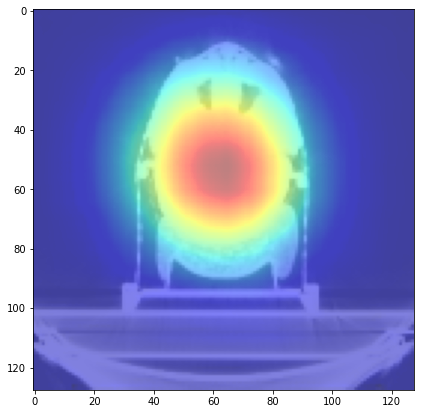

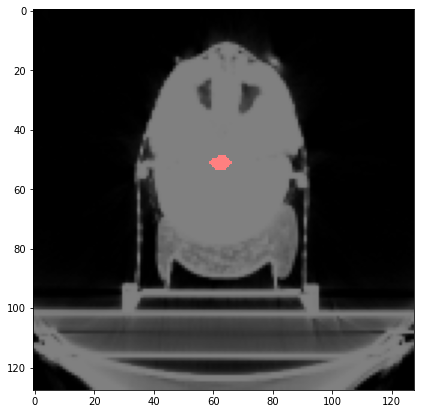

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(65.7391, device='cuda:0', dtype=torch.float64) tensor(47.6646, device='cuda:0', dtype=torch.float64) tensor(52.6522, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(63.4178, dtype=torch.float64) tensor(47.0700, dtype=torch.float64) tensor(51.7948, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


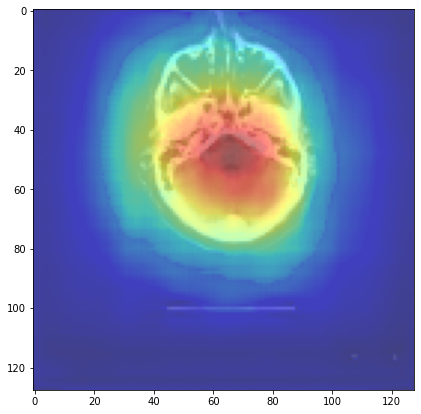

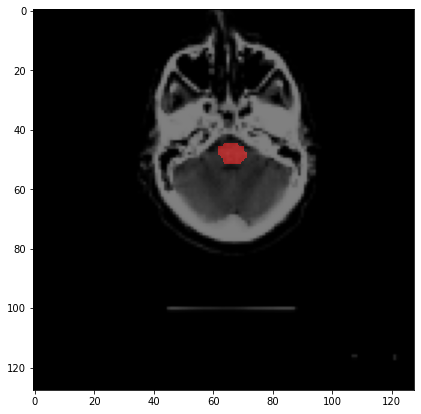

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(62.8000, device='cuda:0', dtype=torch.float64) tensor(43.1667, device='cuda:0', dtype=torch.float64) tensor(55.1167, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(60.6375, dtype=torch.float64) tensor(46.0738, dtype=torch.float64) tensor(55.2611, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


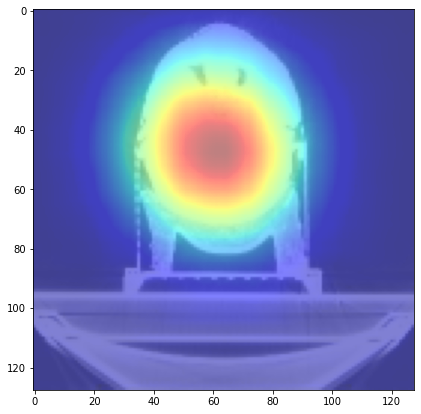

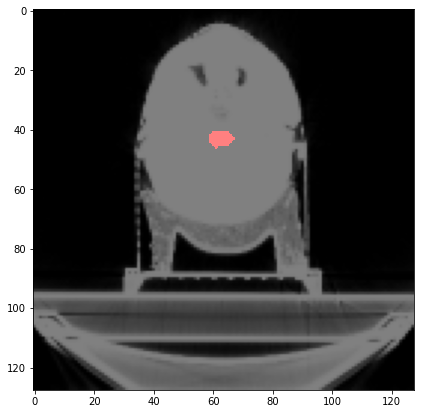

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(62.2814, device='cuda:0', dtype=torch.float64) tensor(57.6332, device='cuda:0', dtype=torch.float64) tensor(52.4095, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(61.7506, dtype=torch.float64) tensor(58.4188, dtype=torch.float64) tensor(52.6550, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


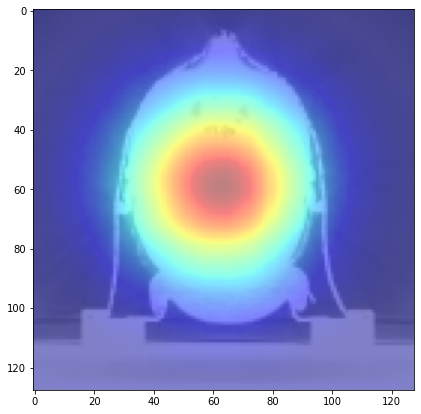

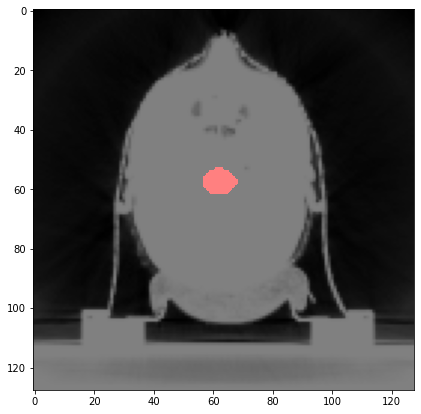

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(65.8333, device='cuda:0', dtype=torch.float64) tensor(81.3381, device='cuda:0', dtype=torch.float64) tensor(50.1238, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(64.7661, dtype=torch.float64) tensor(79.9040, dtype=torch.float64) tensor(51.0423, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


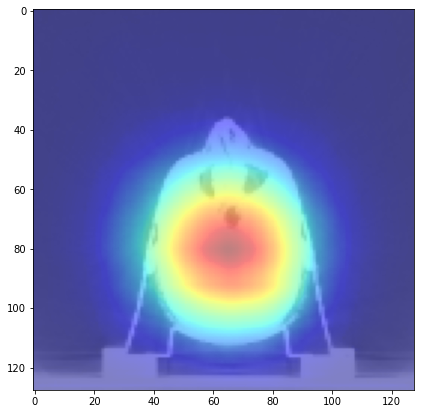

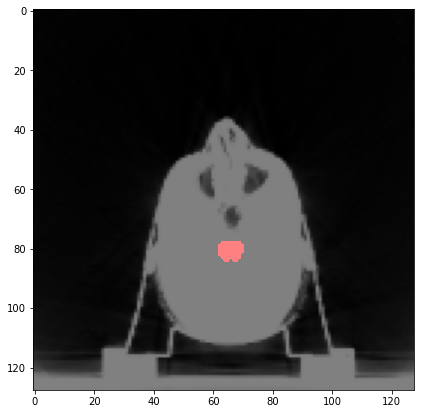

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(65.0364, device='cuda:0', dtype=torch.float64) tensor(40.7818, device='cuda:0', dtype=torch.float64) tensor(19.0727, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(63.6828, dtype=torch.float64) tensor(41.3275, dtype=torch.float64) tensor(18.5392, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


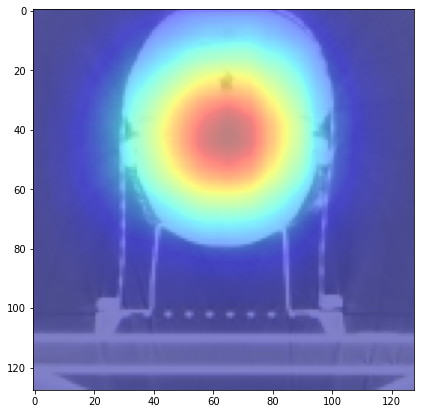

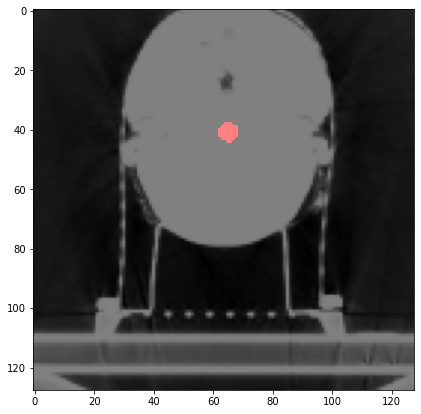

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(65.1607, device='cuda:0', dtype=torch.float64) tensor(66.8837, device='cuda:0', dtype=torch.float64) tensor(30.2438, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(64.4096, dtype=torch.float64) tensor(63.6644, dtype=torch.float64) tensor(29.0858, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


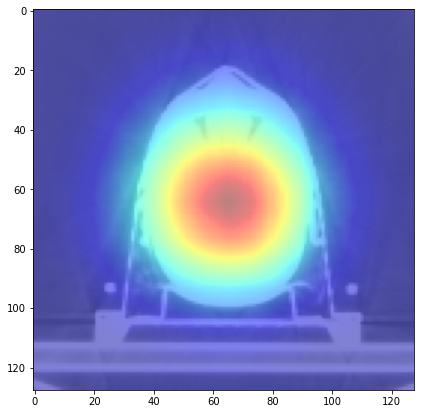

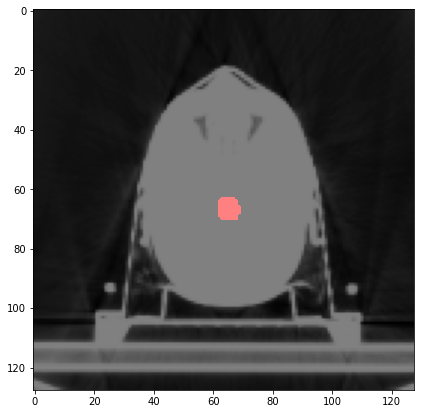

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(63.3154, device='cuda:0', dtype=torch.float64) tensor(51.6154, device='cuda:0', dtype=torch.float64) tensor(53.8231, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(61.5011, dtype=torch.float64) tensor(55.9231, dtype=torch.float64) tensor(54.9106, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


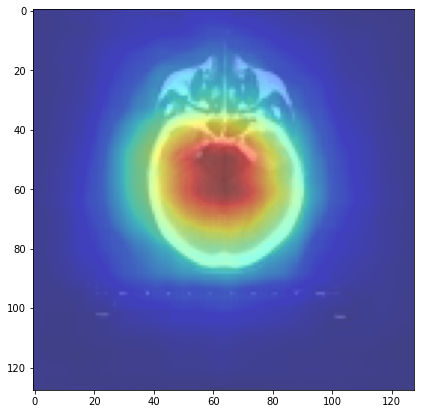

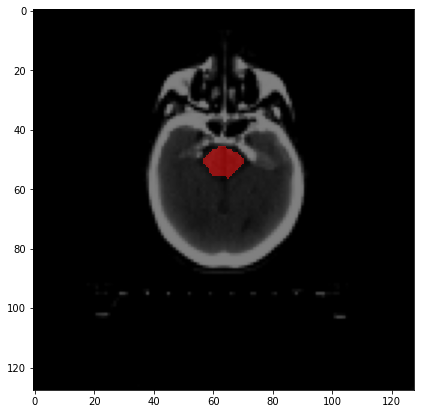

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(60.8662, device='cuda:0', dtype=torch.float64) tensor(46.1776, device='cuda:0', dtype=torch.float64) tensor(63.3509, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(58.9954, dtype=torch.float64) tensor(47.1355, dtype=torch.float64) tensor(64.7613, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


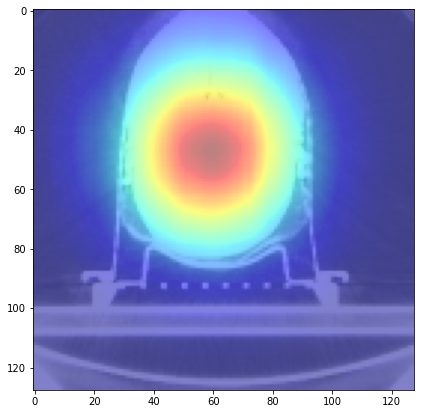

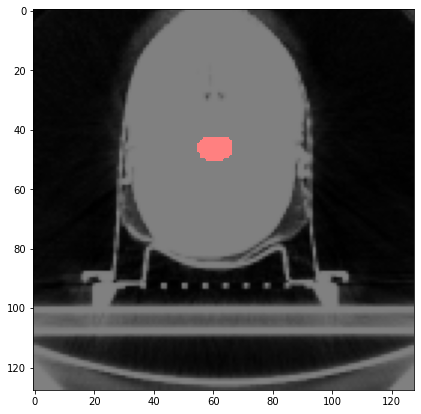

torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
Structure COM:
tensor(65.0203, device='cuda:0', dtype=torch.float64) tensor(50.7804, device='cuda:0', dtype=torch.float64) tensor(58.5845, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(62.7827, dtype=torch.float64) tensor(57.2776, dtype=torch.float64) tensor(60.5352, dtype=torch.float64)
torch.cuda.FloatTensor
torch.cuda.FloatTensor
image and predicted heatmap
image and structure


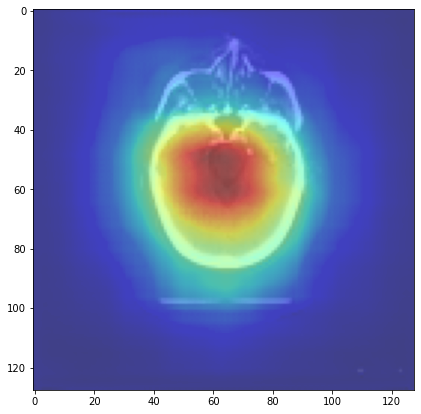

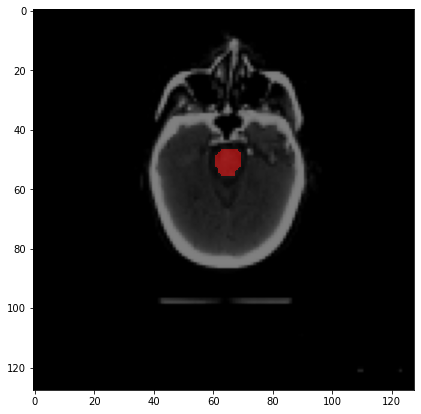



Landmark 3
    mean point to point error is 9.300699162520106+/-1.5165543249258888
    median point to point error is 8.678827373089376
    percentage of images which were outliers is 0.0%
    sigma is Parameter containing:
tensor([21.8666], device='cuda:0', requires_grad=True)




In [26]:
# evaluate initialised model
!nvidia-smi
model.eval()   # Set model to the evaluation mode
test_set.dataset.__test__() # sets whole dataset to test mode means it doesn't augment images
performance_metrics(model,sigmas,gamma)


In [ ]:
# train loaded in model

# load in val loss
best_loss = torch.load(PATH_val_loss_load)['best_val_loss']

train_set.dataset.__train__() 
model_load, best_loss = train_model(model_load, scaler_load, optimizer_load, scheduler, alpha,reg,gamma,sigmas, num_epochs=epoch_num, best_loss = best_loss)

Mon Jan 04 11:09:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.41       Driver Version: 452.41       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   42C    P0    17W /  N/A |   1338MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

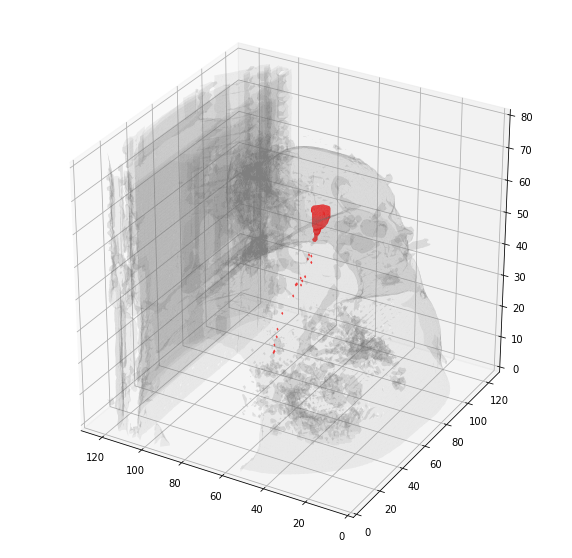

Structure COM:
tensor(62.5435, device='cuda:0', dtype=torch.float64) tensor(50.4783, device='cuda:0', dtype=torch.float64) tensor(59.3043, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(64, device='cuda:0') tensor(53, device='cuda:0') tensor(58, device='cuda:0')
torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
torch.cuda.FloatTensor
torch.cuda.FloatTensor


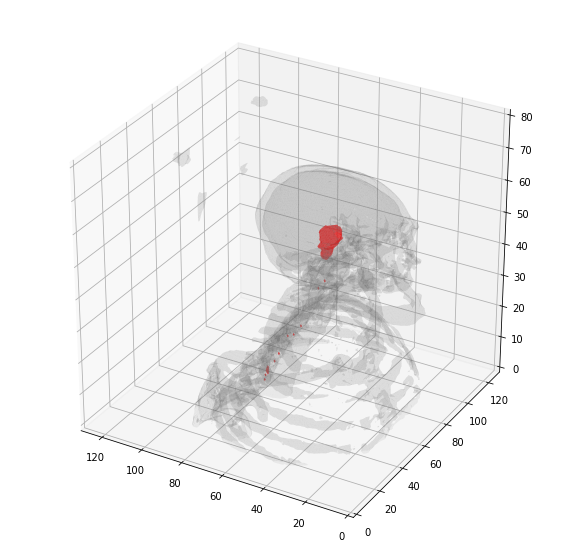

Structure COM:
tensor(65.7391, device='cuda:0', dtype=torch.float64) tensor(47.6646, device='cuda:0', dtype=torch.float64) tensor(52.6522, device='cuda:0', dtype=torch.float64)
Predicted COM:
tensor(67, device='cuda:0') tensor(51, device='cuda:0') tensor(52, device='cuda:0')
torch.Size([1, 1, 128, 128, 80])
3D plots for landmark 3
torch.cuda.FloatTensor
torch.cuda.FloatTensor


KeyboardInterrupt: 

In [43]:
# evaluate loaded in model
!nvidia-smi

best_loss = torch.load(PATH_val_loss_load)['best_val_loss']
print(best_loss)

model_load.eval()
test_set.dataset.__test__() # sets whole dataset to test mode means it doesn't augment images
performance_metrics(model_load,sigmas,gamma)


In [22]:
# save intialised model to documents

"""
# careful if uncommenting below could overwrite!!!

torch.save(model.state_dict(), PATH_save)
torch.save(optimizer.state_dict(), PATH_opt_save)
torch.save({
            'sigma_3': sigmas[3],
            }, PATH_sigma_save) # change accordingly
torch.save(scaler.state_dict(), PATH_scaler_save)
torch.save({'best_val_loss': best_loss}, PATH_val_loss_save)
"""

In [20]:
# save loaded in model to documents

# careful if uncommenting below could overwrite!!!

"""
torch.save(model_load.state_dict(), PATH_save)
torch.save(optimizer_load.state_dict(), PATH_opt_save)
torch.save({
            'sigma_3': sigmas[3],
            }, PATH_sigma_save) # change accordingly
torch.save(scaler_load.state_dict(), PATH_scaler_save)
torch.save({'best_val_loss': best_loss}, PATH_val_loss_save)
"""